## Importing Libraries

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AI_Practical_Sessions_24_25/Project

Mounted at /gdrive
/gdrive/My Drive/AI_Practical_Sessions_24_25/Project


In [3]:
!pip install pynrrd

In [5]:
!pip install xgboost

In [6]:
!pip install shap

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nrrd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import DMatrix, train
import xgboost as xgb
import shap
from collections import Counter
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import layers, models, optimizers
from skimage.transform import resize
from tqdm import tqdm

## Loading the Data

In [7]:
# Load the metadata
metadata_path = 'updated_dataset.csv'
data = pd.read_csv(metadata_path)

# Filter for relevant images
image_folder = 'Train'
data = data[['Full_slice', 'TumorClass']]
data['Full_slice'] = data['Full_slice'].str.strip()

In [8]:
# Paths
train_folder = "train_subjects2"
val_folder = "val_subjects2"

# Function to load individual files
def load_individual_files(folder):
    images, labels = [], []
    for file in tqdm(os.listdir(folder), desc=f"Loading data from {folder}"):
        if file.endswith("_image.npy"):
            image = np.load(os.path.join(folder, file))
            label_file = file.replace("_image.npy", "_label.npy")
            label = np.load(os.path.join(folder, label_file))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load datasets
train_images, train_labels = load_individual_files(train_folder)
val_images, val_labels = load_individual_files(val_folder)

Loading data from val_subjects2: 100%|██████████| 946/946 [00:46<00:00, 20.42it/s]


## Data Preprocessing (no need to run because they are already saved locally!)

In [ ]:
# Load the metadata
metadata_path = 'updated_dataset.csv'
data = pd.read_csv(metadata_path)

# Filter for relevant images
image_folder = 'Train'
data = data[['Full_slice', 'TumorClass']]
data['Full_slice'] = data['Full_slice'].str.strip()  # Ensure filenames are clean

# Split the data into training and validation sets
train_data, val_data = train_test_split(
    data, test_size=0.2, stratify=data['TumorClass'], random_state=42
)

# Function to process and save images one by one
def process_and_save_images(data_subset, output_image_file, output_label_file):
    images = []
    labels = []
    for _, row in tqdm(data_subset.iterrows(), total=len(data_subset)):
        file_path = os.path.join(image_folder, row['Full_slice'])
        if os.path.exists(file_path):
            # Load the image
            if file_path.endswith('.nrrd'):
                image, _ = nrrd.read(file_path)
            else:
                image = nib.load(file_path).get_fdata()

            # Resize the image to 300x300
            image_resized = resize(image, (300, 300), anti_aliasing=True)

            # Normalize pixel values based on range
            max_val = np.max(image_resized)
            image_normalized = (image_resized - np.min(image_resized)) / (np.max(image_resized) - np.min(image_resized))

            # Convert to 3-channel by stacking grayscale image
            image_3channel = np.stack([image_normalized] * 3, axis=-1)

            images.append(image_3channel)
            labels.append(row['TumorClass'])

    # Convert to arrays and save them
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    np.save(output_image_file, images)
    np.save(output_label_file, labels)

# Process and save training images and labels
process_and_save_images(train_data, 'processed_images_train2.npy', 'processed_labels_train2.npy')

# Process and save validation images and labels
process_and_save_images(val_data, 'processed_images_val2.npy', 'processed_labels_val2.npy')

print("Processing complete. Data saved locally.")

In [ ]:
# Function to get the number and dimensions of resized images
def get_resized_image_statistics(npy_file):
    images = np.load(npy_file, mmap_mode='r')  # Memory-efficient loading
    num_images = images.shape[0]
    dimensions = images.shape[1:]  # Exclude the number of images
    return num_images, dimensions

# Get training statistics
train_num_images, train_dimensions = get_resized_image_statistics('processed_images_train2.npy')
print(f"Number of training images: {train_num_images}")
print(f"Dimensions of each training image: {train_dimensions}")

# Get validation statistics
val_num_images, val_dimensions = get_resized_image_statistics('processed_images_val2.npy')
print(f"Number of validation images: {val_num_images}")
print(f"Dimensions of each validation image: {val_dimensions}")

In [ ]:
# Create directories for individual subject files
train_folder = "train_subjects2"
val_folder = "val_subjects2"
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

def save_individual_files(images_file, labels_file, output_folder):
    images = np.load(images_file)
    labels = np.load(labels_file)

    for i in tqdm(range(len(images)), desc=f"Saving individual files to {output_folder}"):
        # Save each subject's data
        image_path = os.path.join(output_folder, f"subject_{i}_image.npy")
        label_path = os.path.join(output_folder, f"subject_{i}_label.npy")

        np.save(image_path, images[i])
        np.save(label_path, labels[i])

# Process train and validation datasets
save_individual_files("processed_images_train2.npy", "processed_labels_train2.npy", train_folder)
save_individual_files("processed_images_val2.npy", "processed_labels_val2.npy", val_folder)

print("Data successfully split into individual files.")

## Exploratory Data Analysis (EDA)

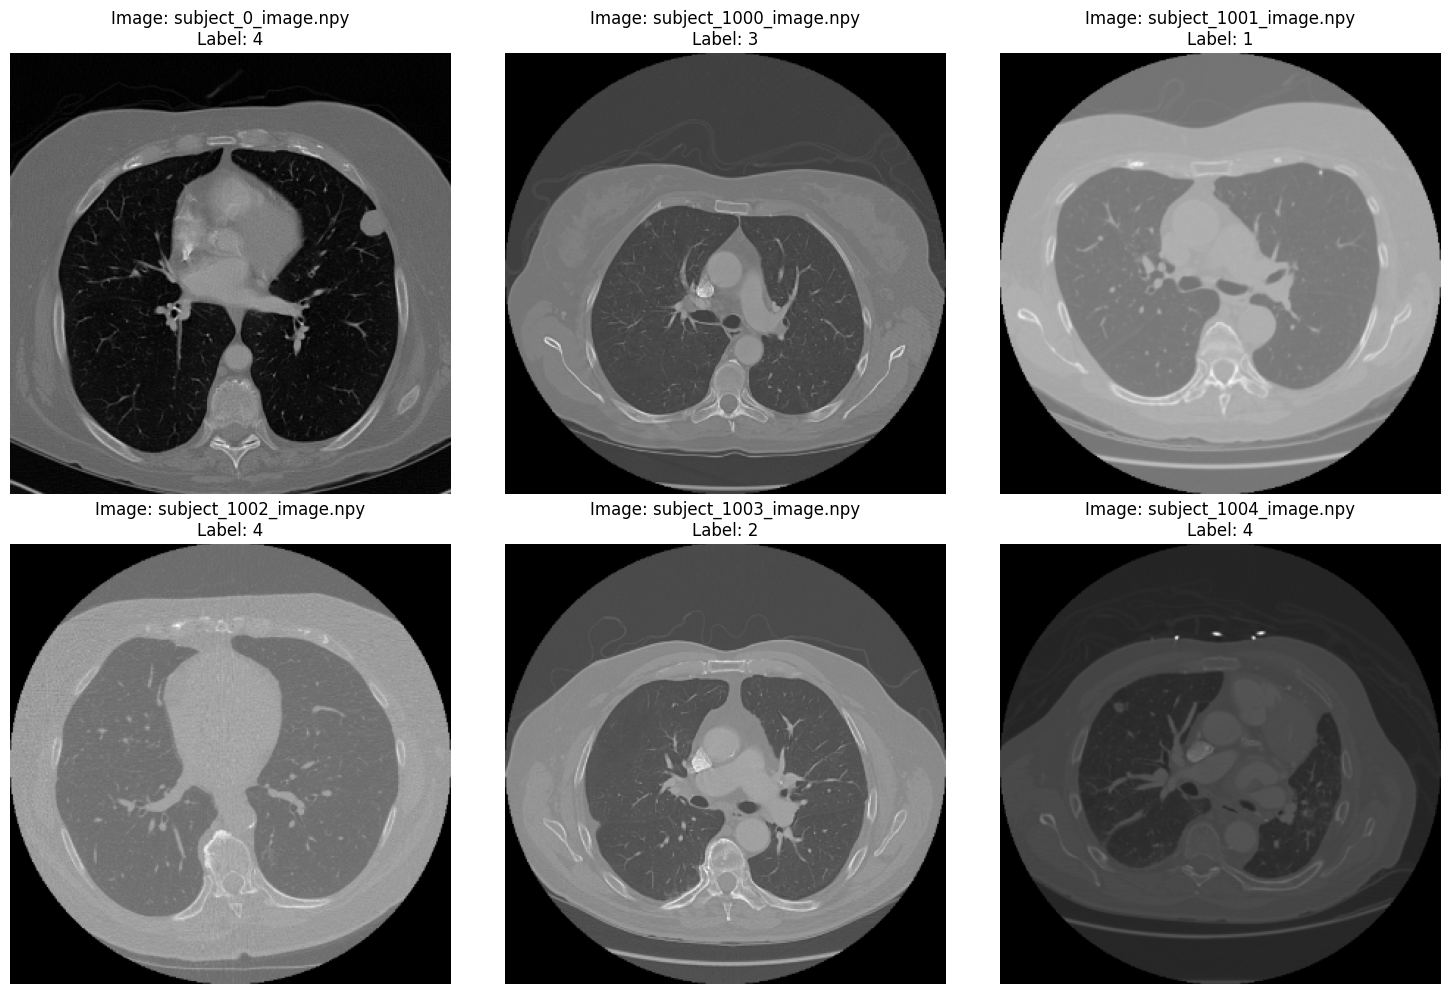

In [9]:
# Define the folder path
folder_path = "train_subjects2"

# Get the list of image and label files
image_files = sorted([f for f in os.listdir(folder_path) if "_image.npy" in f])
label_files = sorted([f for f in os.listdir(folder_path) if "_label.npy" in f])

# Ensure there are corresponding image and label files
assert len(image_files) == len(label_files), "Mismatch between image and label files!"

# Number of images to display
num_images_to_display = 6

# Display the images and labels
plt.figure(figsize=(15, 10))
for i in range(min(num_images_to_display, len(image_files))):
    # Load the image and label
    image = np.load(os.path.join(folder_path, image_files[i]))
    label = np.load(os.path.join(folder_path, label_files[i]))

    # If the label is an array, get the value
    if isinstance(label, np.ndarray):
        label_value = label.item() if label.size == 1 else label
    else:
        label_value = label

    # Plot the image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image: {image_files[i]}\nLabel: {label_value}")
    plt.axis('off')

plt.tight_layout()
plt.show()

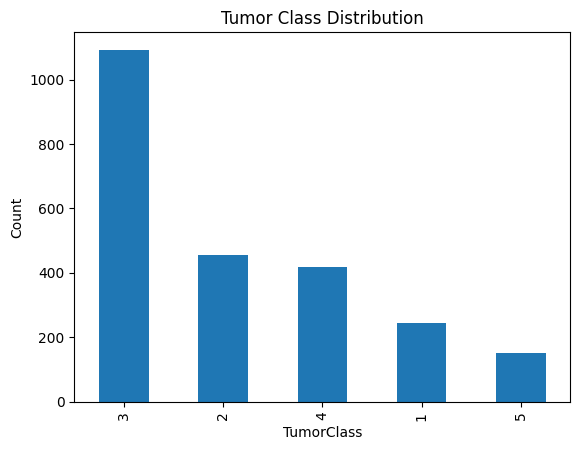

In [10]:
# Plot tumor class distribution
data['TumorClass'].value_counts().plot(kind='bar')
plt.title('Tumor Class Distribution')
plt.ylabel('Count')
plt.show()

## Feature Extraction

In [11]:
# Feature extraction model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Feature extraction
def extract_features(images):
    features = []
    for image in tqdm(images, desc="Extracting features"):
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)
        feature = feature_extractor.predict(image)
        features.append(feature)
    return np.vstack(features)

# Extract features for training and validation datasets
train_features = extract_features(train_images)
val_features = extract_features(val_images)

print(f"Extracted train features shape: {train_features.shape}")
print(f"Extracted val features shape: {val_features.shape}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/1890 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Extracting features:   0%|          | 1/1890 [00:09<5:10:17,  9.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:   0%|          | 2/1890 [00:10<2:10:26,  4.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   0%|          | 3/1890 [00:10<1:12:46,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   0%|          | 4/1890 [00:10<45:42,  1.45s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   0%|          | 5/1890 [00:10<30:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   0%|          | 6/1890 [00:10<21:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   0%|          | 7/1890 [00:10<15:27,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   0%|          | 8/1890 [00:10<11:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   1%|          | 10/1890 [00:10<07:28,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Extracting features:   1%|          | 11/1890 [00:11<06:25,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   1%|          | 13/1890 [00:11<04:41,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   1%|          | 15/1890 [00:11<03:57,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   1%|          | 17/1890 [00:11<03:47,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   1%|          | 19/1890 [00:11<03:18,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   1%|          | 21/1890 [00:11<02:58, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   1%|          | 23/1890 [00:12<03:07,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   1%|▏         | 25/1890 [00:12<02:53, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   1%|▏         | 27/1890 [00:12<02:51, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   2%|▏         | 29/1890 [00:12<03:03, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   2%|▏         | 31/1890 [00:12<02:59, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   2%|▏         | 33/1890 [00:13<03:05, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   2%|▏         | 35/1890 [00:13<03:08,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   2%|▏         | 37/1890 [00:13<03:03, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   2%|▏         | 39/1890 [00:13<03:08,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   2%|▏         | 41/1890 [00:13<03:02, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   2%|▏         | 43/1890 [00:14<03:07,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   2%|▏         | 45/1890 [00:14<02:50, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   2%|▏         | 47/1890 [00:14<02:38, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   3%|▎         | 49/1890 [00:14<02:45, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   3%|▎         | 51/1890 [00:14<02:46, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   3%|▎         | 53/1890 [00:14<02:36, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   3%|▎         | 55/1890 [00:15<02:37, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   3%|▎         | 57/1890 [00:15<02:38, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   3%|▎         | 59/1890 [00:15<02:43, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   3%|▎         | 61/1890 [00:15<02:49, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   3%|▎         | 63/1890 [00:15<02:48, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   3%|▎         | 65/1890 [00:16<02:55, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   4%|▎         | 67/1890 [00:16<02:55, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▎         | 69/1890 [00:16<02:51, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▍         | 71/1890 [00:16<02:52, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▍         | 73/1890 [00:16<03:00, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   4%|▍         | 75/1890 [00:16<02:47, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▍         | 77/1890 [00:17<02:48, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   4%|▍         | 79/1890 [00:17<02:55, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▍         | 81/1890 [00:17<03:03,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   4%|▍         | 82/1890 [00:17<03:05,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   4%|▍         | 84/1890 [00:17<02:49, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▍         | 86/1890 [00:18<02:49, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   5%|▍         | 88/1890 [00:18<02:50, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   5%|▍         | 90/1890 [00:18<02:46, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   5%|▍         | 92/1890 [00:18<02:56, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   5%|▍         | 94/1890 [00:18<03:00,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   5%|▌         | 96/1890 [00:18<02:47, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   5%|▌         | 98/1890 [00:19<02:39, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:   5%|▌         | 100/1890 [00:19<02:39, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   5%|▌         | 102/1890 [00:19<02:52, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   6%|▌         | 104/1890 [00:19<02:38, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   6%|▌         | 106/1890 [00:19<02:47, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   6%|▌         | 108/1890 [00:20<02:45, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   6%|▌         | 110/1890 [00:20<02:56, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   6%|▌         | 112/1890 [00:20<03:08,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   6%|▌         | 113/1890 [00:20<03:17,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   6%|▌         | 114/1890 [00:20<03:17,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   6%|▌         | 115/1890 [00:20<03:15,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   6%|▌         | 116/1890 [00:21<03:18,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   6%|▌         | 117/1890 [00:21<03:25,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   6%|▌         | 118/1890 [00:21<03:21,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   6%|▋         | 119/1890 [00:21<03:19,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:   6%|▋         | 120/1890 [00:21<03:41,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:   6%|▋         | 121/1890 [00:21<03:50,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▋         | 122/1890 [00:21<03:37,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:   7%|▋         | 123/1890 [00:21<03:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 124/1890 [00:22<03:36,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:   7%|▋         | 125/1890 [00:22<03:24,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 126/1890 [00:22<03:35,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:   7%|▋         | 127/1890 [00:22<03:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   7%|▋         | 128/1890 [00:22<03:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:   7%|▋         | 130/1890 [00:22<03:20,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:   7%|▋         | 131/1890 [00:22<03:28,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 132/1890 [00:22<03:36,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:   7%|▋         | 133/1890 [00:23<03:42,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   7%|▋         | 134/1890 [00:23<03:33,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   7%|▋         | 135/1890 [00:23<03:41,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:   7%|▋         | 136/1890 [00:23<03:53,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:   7%|▋         | 137/1890 [00:23<04:42,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:   7%|▋         | 138/1890 [00:23<04:27,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   7%|▋         | 139/1890 [00:23<04:15,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   7%|▋         | 140/1890 [00:24<03:55,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   7%|▋         | 141/1890 [00:24<03:41,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 143/1890 [00:24<03:15,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   8%|▊         | 145/1890 [00:24<02:58,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 147/1890 [00:24<02:52, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 148/1890 [00:24<02:56,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 150/1890 [00:25<02:49, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   8%|▊         | 152/1890 [00:25<02:55,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   8%|▊         | 153/1890 [00:25<03:02,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   8%|▊         | 154/1890 [00:25<03:08,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 155/1890 [00:25<03:08,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   8%|▊         | 156/1890 [00:25<03:10,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   8%|▊         | 157/1890 [00:25<03:10,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   8%|▊         | 158/1890 [00:25<03:11,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   8%|▊         | 160/1890 [00:26<02:44, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   9%|▊         | 162/1890 [00:26<02:41, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   9%|▊         | 164/1890 [00:26<02:58,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:   9%|▊         | 165/1890 [00:26<02:59,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:   9%|▉         | 166/1890 [00:26<03:01,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   9%|▉         | 167/1890 [00:26<03:01,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   9%|▉         | 169/1890 [00:27<02:54,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:   9%|▉         | 171/1890 [00:27<02:47, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   9%|▉         | 173/1890 [00:27<02:47, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:   9%|▉         | 175/1890 [00:27<02:47, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:   9%|▉         | 177/1890 [00:27<02:44, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting features:   9%|▉         | 179/1890 [00:27<02:31, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  10%|▉         | 181/1890 [00:28<02:34, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  10%|▉         | 183/1890 [00:28<02:45, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  10%|▉         | 185/1890 [00:28<02:48, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  10%|▉         | 187/1890 [00:28<02:53,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  10%|█         | 189/1890 [00:28<02:40, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  10%|█         | 191/1890 [00:29<02:47, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  10%|█         | 193/1890 [00:29<02:39, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  10%|█         | 195/1890 [00:29<02:53,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  10%|█         | 197/1890 [00:29<02:56,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  10%|█         | 198/1890 [00:29<02:57,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  11%|█         | 200/1890 [00:30<02:50,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  11%|█         | 201/1890 [00:30<02:52,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  11%|█         | 202/1890 [00:30<02:55,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  11%|█         | 204/1890 [00:30<02:54,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  11%|█         | 206/1890 [00:30<02:41, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  11%|█         | 208/1890 [00:30<02:39, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  11%|█         | 210/1890 [00:31<02:37, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  11%|█         | 212/1890 [00:31<02:34, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  11%|█▏        | 214/1890 [00:31<02:37, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  11%|█▏        | 216/1890 [00:31<02:51,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  11%|█▏        | 217/1890 [00:31<02:53,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  12%|█▏        | 219/1890 [00:31<02:36, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  12%|█▏        | 221/1890 [00:32<02:35, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  12%|█▏        | 223/1890 [00:32<02:25, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  12%|█▏        | 225/1890 [00:32<02:31, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  12%|█▏        | 227/1890 [00:32<02:28, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  12%|█▏        | 229/1890 [00:32<02:31, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  12%|█▏        | 231/1890 [00:32<02:25, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  12%|█▏        | 233/1890 [00:33<02:37, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  12%|█▏        | 235/1890 [00:33<02:44, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  13%|█▎        | 237/1890 [00:33<02:44, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  13%|█▎        | 239/1890 [00:33<02:36, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  13%|█▎        | 241/1890 [00:33<02:41, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  13%|█▎        | 243/1890 [00:34<02:52,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  13%|█▎        | 244/1890 [00:34<02:52,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  13%|█▎        | 245/1890 [00:34<03:05,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  13%|█▎        | 246/1890 [00:34<03:14,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  13%|█▎        | 248/1890 [00:34<03:00,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  13%|█▎        | 250/1890 [00:34<02:50,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  13%|█▎        | 251/1890 [00:35<02:56,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  13%|█▎        | 252/1890 [00:35<03:11,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  13%|█▎        | 253/1890 [00:35<03:17,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  13%|█▎        | 254/1890 [00:35<03:27,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  13%|█▎        | 255/1890 [00:35<03:29,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  14%|█▎        | 256/1890 [00:35<03:19,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  14%|█▎        | 257/1890 [00:35<03:16,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  14%|█▎        | 258/1890 [00:36<03:09,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  14%|█▎        | 259/1890 [00:36<03:02,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  14%|█▍        | 260/1890 [00:36<03:09,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  14%|█▍        | 261/1890 [00:36<03:01,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  14%|█▍        | 262/1890 [00:36<03:13,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  14%|█▍        | 263/1890 [00:36<03:12,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  14%|█▍        | 264/1890 [00:36<03:27,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  14%|█▍        | 265/1890 [00:36<03:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  14%|█▍        | 266/1890 [00:36<03:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  14%|█▍        | 267/1890 [00:37<03:22,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  14%|█▍        | 268/1890 [00:37<03:28,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  14%|█▍        | 269/1890 [00:37<03:40,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  14%|█▍        | 270/1890 [00:37<03:38,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  14%|█▍        | 271/1890 [00:37<03:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  14%|█▍        | 272/1890 [00:37<03:34,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  14%|█▍        | 273/1890 [00:37<03:34,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  15%|█▍        | 275/1890 [00:38<03:02,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  15%|█▍        | 277/1890 [00:38<02:49,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  15%|█▍        | 278/1890 [00:38<02:51,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  15%|█▍        | 280/1890 [00:38<02:36, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  15%|█▍        | 282/1890 [00:38<02:41,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  15%|█▍        | 283/1890 [00:38<02:45,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  15%|█▌        | 284/1890 [00:39<02:47,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  15%|█▌        | 286/1890 [00:39<02:31, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  15%|█▌        | 288/1890 [00:39<02:20, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  15%|█▌        | 290/1890 [00:39<02:28, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  15%|█▌        | 292/1890 [00:39<02:30, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  16%|█▌        | 294/1890 [00:39<02:24, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  16%|█▌        | 296/1890 [00:40<02:17, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  16%|█▌        | 298/1890 [00:40<02:27, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  16%|█▌        | 300/1890 [00:40<02:22, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  16%|█▌        | 302/1890 [00:40<02:20, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  16%|█▌        | 304/1890 [00:40<02:22, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  16%|█▌        | 306/1890 [00:40<02:26, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  16%|█▋        | 308/1890 [00:41<02:27, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:  16%|█▋        | 310/1890 [00:41<02:25, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  17%|█▋        | 312/1890 [00:41<02:31, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  17%|█▋        | 314/1890 [00:41<02:24, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  17%|█▋        | 316/1890 [00:41<02:20, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  17%|█▋        | 318/1890 [00:42<02:29, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  17%|█▋        | 320/1890 [00:42<02:27, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  17%|█▋        | 322/1890 [00:42<02:30, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  17%|█▋        | 324/1890 [00:42<02:29, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  17%|█▋        | 326/1890 [00:42<02:27, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  17%|█▋        | 328/1890 [00:43<02:20, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  17%|█▋        | 330/1890 [00:43<02:28, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  18%|█▊        | 332/1890 [00:43<02:19, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  18%|█▊        | 334/1890 [00:43<02:30, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  18%|█▊        | 336/1890 [00:43<02:29, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  18%|█▊        | 338/1890 [00:43<02:24, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  18%|█▊        | 340/1890 [00:44<02:24, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  18%|█▊        | 342/1890 [00:44<02:30, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  18%|█▊        | 344/1890 [00:44<02:38,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  18%|█▊        | 345/1890 [00:44<02:40,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  18%|█▊        | 346/1890 [00:44<02:42,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  18%|█▊        | 347/1890 [00:44<02:43,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  18%|█▊        | 349/1890 [00:45<02:38,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  19%|█▊        | 350/1890 [00:45<02:41,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  19%|█▊        | 352/1890 [00:45<02:24, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  19%|█▊        | 354/1890 [00:45<02:37,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  19%|█▉        | 355/1890 [00:45<02:40,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  19%|█▉        | 357/1890 [00:45<02:23, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Extracting features:  19%|█▉        | 359/1890 [00:46<02:22, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  19%|█▉        | 361/1890 [00:46<02:32, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  19%|█▉        | 363/1890 [00:46<02:39,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  19%|█▉        | 364/1890 [00:46<02:40,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  19%|█▉        | 366/1890 [00:46<02:37,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  19%|█▉        | 367/1890 [00:46<02:40,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  19%|█▉        | 368/1890 [00:47<02:43,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  20%|█▉        | 370/1890 [00:47<02:32, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  20%|█▉        | 372/1890 [00:47<02:28, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  20%|█▉        | 374/1890 [00:47<02:28, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  20%|█▉        | 376/1890 [00:47<02:25, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  20%|██        | 378/1890 [00:48<02:34,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:  20%|██        | 379/1890 [00:48<02:52,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  20%|██        | 380/1890 [00:48<02:59,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  20%|██        | 381/1890 [00:48<03:03,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  20%|██        | 382/1890 [00:48<03:01,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  20%|██        | 383/1890 [00:48<03:03,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  20%|██        | 384/1890 [00:48<03:08,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  20%|██        | 385/1890 [00:48<03:00,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  20%|██        | 386/1890 [00:49<03:04,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  20%|██        | 387/1890 [00:49<03:16,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  21%|██        | 388/1890 [00:49<03:17,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  21%|██        | 389/1890 [00:49<03:19,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  21%|██        | 390/1890 [00:49<03:05,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  21%|██        | 392/1890 [00:49<02:54,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  21%|██        | 394/1890 [00:50<02:44,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  21%|██        | 395/1890 [00:50<02:42,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  21%|██        | 396/1890 [00:50<02:55,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  21%|██        | 398/1890 [00:50<02:51,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  21%|██        | 399/1890 [00:50<02:54,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  21%|██        | 400/1890 [00:50<03:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  21%|██        | 401/1890 [00:50<03:07,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  21%|██▏       | 402/1890 [00:51<03:04,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  21%|██▏       | 403/1890 [00:51<02:57,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  21%|██▏       | 404/1890 [00:51<03:07,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  21%|██▏       | 405/1890 [00:51<03:08,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  21%|██▏       | 406/1890 [00:51<03:08,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  22%|██▏       | 407/1890 [00:51<03:14,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  22%|██▏       | 408/1890 [00:51<03:19,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  22%|██▏       | 409/1890 [00:51<03:19,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  22%|██▏       | 410/1890 [00:52<03:09,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  22%|██▏       | 411/1890 [00:52<03:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  22%|██▏       | 412/1890 [00:52<02:57,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  22%|██▏       | 413/1890 [00:52<02:52,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  22%|██▏       | 414/1890 [00:52<02:55,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  22%|██▏       | 415/1890 [00:52<02:52,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  22%|██▏       | 416/1890 [00:52<02:48,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  22%|██▏       | 417/1890 [00:52<02:46,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  22%|██▏       | 418/1890 [00:52<02:46,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  22%|██▏       | 419/1890 [00:53<02:44,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  22%|██▏       | 420/1890 [00:53<02:45,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  22%|██▏       | 421/1890 [00:53<02:43,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  22%|██▏       | 422/1890 [00:53<02:46,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  22%|██▏       | 423/1890 [00:53<02:49,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  22%|██▏       | 424/1890 [00:53<02:47,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  23%|██▎       | 426/1890 [00:53<02:22, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  23%|██▎       | 428/1890 [00:53<02:11, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  23%|██▎       | 430/1890 [00:54<02:12, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  23%|██▎       | 432/1890 [00:54<02:21, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  23%|██▎       | 434/1890 [00:54<02:29,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  23%|██▎       | 435/1890 [00:54<02:30,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  23%|██▎       | 436/1890 [00:54<02:33,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  23%|██▎       | 437/1890 [00:54<02:35,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  23%|██▎       | 439/1890 [00:55<02:26,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  23%|██▎       | 440/1890 [00:55<02:29,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  23%|██▎       | 442/1890 [00:55<02:16, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  23%|██▎       | 444/1890 [00:55<02:28,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  24%|██▎       | 446/1890 [00:55<02:25,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  24%|██▎       | 447/1890 [00:55<02:28,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  24%|██▍       | 449/1890 [00:56<02:23, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  24%|██▍       | 450/1890 [00:56<02:26,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  24%|██▍       | 452/1890 [00:56<02:13, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  24%|██▍       | 454/1890 [00:56<02:28,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  24%|██▍       | 456/1890 [00:56<02:17, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  24%|██▍       | 458/1890 [00:56<02:13, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  24%|██▍       | 460/1890 [00:57<02:22, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  24%|██▍       | 462/1890 [00:57<02:11, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  25%|██▍       | 464/1890 [00:57<02:21, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  25%|██▍       | 466/1890 [00:57<02:18, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  25%|██▍       | 468/1890 [00:57<02:17, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  25%|██▍       | 470/1890 [00:58<02:15, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  25%|██▍       | 472/1890 [00:58<02:21, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  25%|██▌       | 474/1890 [00:58<02:26,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  25%|██▌       | 475/1890 [00:58<02:28,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  25%|██▌       | 477/1890 [00:58<02:22,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  25%|██▌       | 478/1890 [00:58<02:25,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  25%|██▌       | 480/1890 [00:59<02:12, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  26%|██▌       | 482/1890 [00:59<02:12, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  26%|██▌       | 484/1890 [00:59<02:24,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  26%|██▌       | 485/1890 [00:59<02:27,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  26%|██▌       | 487/1890 [00:59<02:23,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  26%|██▌       | 489/1890 [01:00<02:18, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  26%|██▌       | 491/1890 [01:00<02:09, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  26%|██▌       | 493/1890 [01:00<02:12, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  26%|██▌       | 495/1890 [01:00<02:19, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  26%|██▋       | 497/1890 [01:00<02:17, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  26%|██▋       | 499/1890 [01:01<02:16, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  27%|██▋       | 501/1890 [01:01<02:06, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  27%|██▋       | 503/1890 [01:01<02:13, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  27%|██▋       | 505/1890 [01:01<02:16, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  27%|██▋       | 507/1890 [01:01<02:15, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  27%|██▋       | 509/1890 [01:01<02:17, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  27%|██▋       | 511/1890 [01:02<02:30,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  27%|██▋       | 512/1890 [01:02<02:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  27%|██▋       | 513/1890 [01:02<02:48,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  27%|██▋       | 514/1890 [01:02<02:53,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  27%|██▋       | 515/1890 [01:02<02:53,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  27%|██▋       | 516/1890 [01:02<02:48,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  27%|██▋       | 517/1890 [01:03<02:42,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  27%|██▋       | 518/1890 [01:03<02:35,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  27%|██▋       | 519/1890 [01:03<02:40,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  28%|██▊       | 520/1890 [01:03<02:48,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  28%|██▊       | 521/1890 [01:03<03:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  28%|██▊       | 522/1890 [01:03<03:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  28%|██▊       | 523/1890 [01:03<02:54,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  28%|██▊       | 524/1890 [01:03<02:45,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  28%|██▊       | 526/1890 [01:04<02:33,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  28%|██▊       | 527/1890 [01:04<02:33,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  28%|██▊       | 528/1890 [01:04<02:34,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  28%|██▊       | 529/1890 [01:04<02:53,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  28%|██▊       | 530/1890 [01:04<02:45,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  28%|██▊       | 531/1890 [01:04<02:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  28%|██▊       | 532/1890 [01:04<03:00,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  28%|██▊       | 533/1890 [01:04<02:50,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  28%|██▊       | 534/1890 [01:05<02:55,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  28%|██▊       | 535/1890 [01:05<02:47,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  28%|██▊       | 536/1890 [01:05<02:54,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  28%|██▊       | 537/1890 [01:05<02:59,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  28%|██▊       | 538/1890 [01:05<02:51,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  29%|██▊       | 539/1890 [01:05<02:49,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  29%|██▊       | 540/1890 [01:05<02:53,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  29%|██▊       | 541/1890 [01:06<02:53,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  29%|██▊       | 542/1890 [01:06<02:44,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  29%|██▊       | 543/1890 [01:06<02:48,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  29%|██▉       | 544/1890 [01:06<02:51,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  29%|██▉       | 545/1890 [01:06<02:53,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  29%|██▉       | 546/1890 [01:06<02:46,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  29%|██▉       | 548/1890 [01:06<02:20,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  29%|██▉       | 550/1890 [01:06<02:08, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  29%|██▉       | 552/1890 [01:07<02:16,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  29%|██▉       | 554/1890 [01:07<02:12, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  29%|██▉       | 556/1890 [01:07<02:14,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  29%|██▉       | 557/1890 [01:07<02:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  30%|██▉       | 559/1890 [01:07<02:15,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  30%|██▉       | 560/1890 [01:08<02:17,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  30%|██▉       | 561/1890 [01:08<02:20,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  30%|██▉       | 563/1890 [01:08<02:13,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  30%|██▉       | 565/1890 [01:08<02:17,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  30%|███       | 567/1890 [01:08<02:08, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  30%|███       | 569/1890 [01:08<02:16,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  30%|███       | 570/1890 [01:09<02:19,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  30%|███       | 571/1890 [01:09<02:20,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  30%|███       | 572/1890 [01:09<02:22,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  30%|███       | 574/1890 [01:09<02:15,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  30%|███       | 576/1890 [01:09<02:12,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  31%|███       | 578/1890 [01:09<02:09, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  31%|███       | 579/1890 [01:09<02:15,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  31%|███       | 580/1890 [01:10<02:17,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  31%|███       | 582/1890 [01:10<02:13,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  31%|███       | 584/1890 [01:10<02:05, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  31%|███       | 586/1890 [01:10<02:05, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  31%|███       | 588/1890 [01:10<02:12,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  31%|███       | 589/1890 [01:10<02:16,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  31%|███       | 590/1890 [01:11<02:17,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  31%|███▏      | 591/1890 [01:11<02:19,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  31%|███▏      | 593/1890 [01:11<02:06, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  31%|███▏      | 595/1890 [01:11<02:09, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  32%|███▏      | 596/1890 [01:11<02:12,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  32%|███▏      | 597/1890 [01:11<02:15,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  32%|███▏      | 598/1890 [01:11<02:17,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  32%|███▏      | 600/1890 [01:12<02:13,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  32%|███▏      | 602/1890 [01:12<02:02, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  32%|███▏      | 604/1890 [01:12<02:11,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  32%|███▏      | 605/1890 [01:12<02:13,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  32%|███▏      | 606/1890 [01:12<02:16,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  32%|███▏      | 607/1890 [01:12<02:17,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  32%|███▏      | 609/1890 [01:13<02:15,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  32%|███▏      | 610/1890 [01:13<02:17,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  32%|███▏      | 611/1890 [01:13<02:18,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  32%|███▏      | 612/1890 [01:13<02:20,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  32%|███▏      | 613/1890 [01:13<02:26,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  32%|███▏      | 614/1890 [01:13<02:24,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  33%|███▎      | 615/1890 [01:13<02:25,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  33%|███▎      | 616/1890 [01:13<02:24,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  33%|███▎      | 617/1890 [01:13<02:25,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  33%|███▎      | 618/1890 [01:14<02:27,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  33%|███▎      | 619/1890 [01:14<02:26,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  33%|███▎      | 621/1890 [01:14<02:14,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  33%|███▎      | 623/1890 [01:14<02:12,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  33%|███▎      | 624/1890 [01:14<02:14,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  33%|███▎      | 625/1890 [01:14<02:18,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  33%|███▎      | 626/1890 [01:14<02:22,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  33%|███▎      | 628/1890 [01:15<02:17,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  33%|███▎      | 630/1890 [01:15<02:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  33%|███▎      | 631/1890 [01:15<02:15,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  33%|███▎      | 632/1890 [01:15<02:16,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  33%|███▎      | 633/1890 [01:15<02:17,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  34%|███▎      | 635/1890 [01:15<02:00, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  34%|███▎      | 637/1890 [01:16<02:00, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Extracting features:  34%|███▍      | 639/1890 [01:16<03:49,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  34%|███▍      | 640/1890 [01:16<04:05,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  34%|███▍      | 641/1890 [01:17<03:48,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  34%|███▍      | 642/1890 [01:17<03:30,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  34%|███▍      | 643/1890 [01:17<03:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  34%|███▍      | 644/1890 [01:17<03:11,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  34%|███▍      | 645/1890 [01:17<02:54,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  34%|███▍      | 646/1890 [01:17<02:44,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  34%|███▍      | 647/1890 [01:17<02:47,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  34%|███▍      | 648/1890 [01:18<02:46,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  34%|███▍      | 649/1890 [01:18<02:44,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features:  34%|███▍      | 650/1890 [01:18<03:03,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:  34%|███▍      | 651/1890 [01:18<03:39,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  34%|███▍      | 652/1890 [01:18<03:21,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  35%|███▍      | 653/1890 [01:18<03:03,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  35%|███▍      | 654/1890 [01:18<03:00,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  35%|███▍      | 655/1890 [01:19<02:56,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  35%|███▍      | 656/1890 [01:19<02:51,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  35%|███▍      | 657/1890 [01:19<02:48,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  35%|███▍      | 658/1890 [01:19<02:48,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  35%|███▍      | 659/1890 [01:19<02:39,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  35%|███▍      | 660/1890 [01:19<02:30,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  35%|███▍      | 661/1890 [01:19<02:28,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  35%|███▌      | 662/1890 [01:19<02:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  35%|███▌      | 663/1890 [01:20<02:34,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  35%|███▌      | 664/1890 [01:20<02:26,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  35%|███▌      | 665/1890 [01:20<02:31,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  35%|███▌      | 666/1890 [01:20<02:36,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  35%|███▌      | 667/1890 [01:20<02:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  35%|███▌      | 668/1890 [01:20<02:47,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  35%|███▌      | 669/1890 [01:20<02:37,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  36%|███▌      | 671/1890 [01:21<02:09,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  36%|███▌      | 673/1890 [01:21<02:05,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  36%|███▌      | 675/1890 [01:21<02:04,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  36%|███▌      | 676/1890 [01:21<02:08,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  36%|███▌      | 677/1890 [01:21<02:12,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  36%|███▌      | 679/1890 [01:21<02:05,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  36%|███▌      | 681/1890 [01:22<02:02,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  36%|███▌      | 683/1890 [01:22<01:52, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  36%|███▌      | 685/1890 [01:22<01:59, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  36%|███▋      | 687/1890 [01:22<02:06,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  36%|███▋      | 689/1890 [01:22<02:02,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  37%|███▋      | 690/1890 [01:22<02:05,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  37%|███▋      | 692/1890 [01:23<02:01,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  37%|███▋      | 693/1890 [01:23<02:03,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  37%|███▋      | 695/1890 [01:23<01:55, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  37%|███▋      | 697/1890 [01:23<01:59,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  37%|███▋      | 699/1890 [01:23<01:59,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  37%|███▋      | 700/1890 [01:23<02:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  37%|███▋      | 702/1890 [01:24<01:52, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  37%|███▋      | 704/1890 [01:24<01:52, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  37%|███▋      | 706/1890 [01:24<01:59,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  37%|███▋      | 708/1890 [01:24<02:03,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  38%|███▊      | 709/1890 [01:24<02:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  38%|███▊      | 711/1890 [01:25<02:04,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  38%|███▊      | 713/1890 [01:25<02:01,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  38%|███▊      | 715/1890 [01:25<02:02,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  38%|███▊      | 716/1890 [01:25<02:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  38%|███▊      | 718/1890 [01:25<02:01,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  38%|███▊      | 720/1890 [01:25<01:57,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  38%|███▊      | 721/1890 [01:26<02:02,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  38%|███▊      | 723/1890 [01:26<01:52, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  38%|███▊      | 725/1890 [01:26<02:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  38%|███▊      | 726/1890 [01:26<02:05,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  39%|███▊      | 728/1890 [01:26<01:58,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  39%|███▊      | 729/1890 [01:26<02:01,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  39%|███▊      | 730/1890 [01:27<02:02,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  39%|███▊      | 731/1890 [01:27<02:03,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  39%|███▉      | 733/1890 [01:27<01:57,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  39%|███▉      | 734/1890 [01:27<01:59,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  39%|███▉      | 735/1890 [01:27<02:05,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  39%|███▉      | 736/1890 [01:27<02:07,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  39%|███▉      | 737/1890 [01:27<02:07,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  39%|███▉      | 739/1890 [01:27<01:59,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  39%|███▉      | 741/1890 [01:28<01:48, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting features:  39%|███▉      | 743/1890 [01:28<01:47, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  39%|███▉      | 745/1890 [01:28<01:55,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  39%|███▉      | 746/1890 [01:28<02:00,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  40%|███▉      | 747/1890 [01:28<02:02,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  40%|███▉      | 749/1890 [01:29<02:00,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  40%|███▉      | 750/1890 [01:29<02:02,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  40%|███▉      | 751/1890 [01:29<02:04,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  40%|███▉      | 752/1890 [01:29<02:05,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  40%|███▉      | 753/1890 [01:29<02:02,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  40%|███▉      | 755/1890 [01:29<01:57,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  40%|████      | 756/1890 [01:29<02:00,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  40%|████      | 758/1890 [01:29<01:51, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  40%|████      | 760/1890 [01:30<01:50, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  40%|████      | 762/1890 [01:30<01:55,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  40%|████      | 763/1890 [01:30<01:59,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  40%|████      | 764/1890 [01:30<02:00,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  40%|████      | 765/1890 [01:30<02:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  41%|████      | 766/1890 [01:30<02:07,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  41%|████      | 767/1890 [01:30<02:15,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  41%|████      | 768/1890 [01:31<02:11,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  41%|████      | 769/1890 [01:31<02:16,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  41%|████      | 770/1890 [01:31<02:25,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  41%|████      | 771/1890 [01:31<02:30,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  41%|████      | 772/1890 [01:31<02:30,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  41%|████      | 773/1890 [01:31<02:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  41%|████      | 774/1890 [01:31<02:26,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  41%|████      | 775/1890 [01:32<02:29,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  41%|████      | 776/1890 [01:32<02:22,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  41%|████      | 777/1890 [01:32<02:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  41%|████      | 778/1890 [01:32<02:30,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  41%|████      | 779/1890 [01:32<02:40,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  41%|████▏     | 780/1890 [01:32<02:35,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  41%|████▏     | 781/1890 [01:32<02:45,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  41%|████▏     | 782/1890 [01:33<02:43,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  41%|████▏     | 783/1890 [01:33<02:30,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  41%|████▏     | 784/1890 [01:33<02:25,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  42%|████▏     | 785/1890 [01:33<02:29,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  42%|████▏     | 786/1890 [01:33<02:29,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  42%|████▏     | 787/1890 [01:33<02:30,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  42%|████▏     | 788/1890 [01:33<02:31,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  42%|████▏     | 789/1890 [01:33<02:34,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  42%|████▏     | 790/1890 [01:34<02:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  42%|████▏     | 791/1890 [01:34<02:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  42%|████▏     | 792/1890 [01:34<02:20,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  42%|████▏     | 793/1890 [01:34<02:29,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  42%|████▏     | 794/1890 [01:34<02:27,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  42%|████▏     | 795/1890 [01:34<02:29,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  42%|████▏     | 796/1890 [01:34<02:35,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  42%|████▏     | 797/1890 [01:35<02:33,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  42%|████▏     | 798/1890 [01:35<02:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  42%|████▏     | 799/1890 [01:35<02:18,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  42%|████▏     | 800/1890 [01:35<02:13,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  42%|████▏     | 801/1890 [01:35<02:12,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  42%|████▏     | 803/1890 [01:35<01:49,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  43%|████▎     | 805/1890 [01:35<01:42, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  43%|████▎     | 807/1890 [01:36<01:49,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  43%|████▎     | 809/1890 [01:36<01:41, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  43%|████▎     | 811/1890 [01:36<01:42, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  43%|████▎     | 813/1890 [01:36<01:44, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  43%|████▎     | 815/1890 [01:36<01:43, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  43%|████▎     | 817/1890 [01:37<01:50,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  43%|████▎     | 818/1890 [01:37<01:52,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  43%|████▎     | 820/1890 [01:37<01:50,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  43%|████▎     | 821/1890 [01:37<01:50,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  44%|████▎     | 823/1890 [01:37<01:50,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  44%|████▎     | 825/1890 [01:37<01:48,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  44%|████▎     | 826/1890 [01:37<01:51,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  44%|████▍     | 828/1890 [01:38<01:42, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  44%|████▍     | 830/1890 [01:38<01:48,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  44%|████▍     | 831/1890 [01:38<01:52,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  44%|████▍     | 832/1890 [01:38<01:54,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  44%|████▍     | 834/1890 [01:38<01:47,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  44%|████▍     | 835/1890 [01:38<01:52,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  44%|████▍     | 836/1890 [01:39<01:53,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  44%|████▍     | 837/1890 [01:39<01:54,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  44%|████▍     | 839/1890 [01:39<01:48,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  44%|████▍     | 840/1890 [01:39<01:48,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  44%|████▍     | 841/1890 [01:39<01:54,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  45%|████▍     | 843/1890 [01:39<01:49,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  45%|████▍     | 844/1890 [01:39<01:51,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  45%|████▍     | 845/1890 [01:40<01:53,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  45%|████▍     | 846/1890 [01:40<02:00,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  45%|████▍     | 847/1890 [01:40<02:02,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  45%|████▍     | 848/1890 [01:40<02:01,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  45%|████▍     | 849/1890 [01:40<02:02,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  45%|████▍     | 850/1890 [01:40<02:01,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  45%|████▌     | 851/1890 [01:40<02:00,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  45%|████▌     | 852/1890 [01:40<01:58,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  45%|████▌     | 853/1890 [01:40<02:01,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  45%|████▌     | 854/1890 [01:41<02:02,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  45%|████▌     | 855/1890 [01:41<02:02,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  45%|████▌     | 856/1890 [01:41<02:00,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  45%|████▌     | 857/1890 [01:41<01:59,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  45%|████▌     | 859/1890 [01:41<01:46,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  46%|████▌     | 861/1890 [01:41<01:45,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  46%|████▌     | 863/1890 [01:41<01:43,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  46%|████▌     | 864/1890 [01:42<01:45,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  46%|████▌     | 865/1890 [01:42<01:49,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  46%|████▌     | 866/1890 [01:42<01:51,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  46%|████▌     | 867/1890 [01:42<01:54,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  46%|████▌     | 868/1890 [01:42<01:55,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  46%|████▌     | 870/1890 [01:42<01:48,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  46%|████▌     | 872/1890 [01:42<01:45,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  46%|████▌     | 874/1890 [01:43<01:44,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  46%|████▋     | 875/1890 [01:43<01:47,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  46%|████▋     | 877/1890 [01:43<01:47,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  46%|████▋     | 878/1890 [01:43<01:48,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  47%|████▋     | 879/1890 [01:43<01:50,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  47%|████▋     | 881/1890 [01:43<01:40, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  47%|████▋     | 882/1890 [01:44<01:43,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  47%|████▋     | 883/1890 [01:44<01:45,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  47%|████▋     | 884/1890 [01:44<01:49,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  47%|████▋     | 886/1890 [01:44<01:45,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  47%|████▋     | 887/1890 [01:44<01:48,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  47%|████▋     | 889/1890 [01:44<01:43,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  47%|████▋     | 890/1890 [01:44<01:45,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  47%|████▋     | 891/1890 [01:44<01:47,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  47%|████▋     | 893/1890 [01:45<01:48,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  47%|████▋     | 894/1890 [01:45<01:55,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  47%|████▋     | 895/1890 [01:45<02:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  47%|████▋     | 896/1890 [01:45<02:06,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  47%|████▋     | 897/1890 [01:45<02:11,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  48%|████▊     | 898/1890 [01:45<02:12,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  48%|████▊     | 899/1890 [01:46<02:10,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  48%|████▊     | 900/1890 [01:46<02:09,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  48%|████▊     | 901/1890 [01:46<02:17,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  48%|████▊     | 902/1890 [01:46<02:19,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  48%|████▊     | 903/1890 [01:46<02:20,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  48%|████▊     | 904/1890 [01:46<02:14,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  48%|████▊     | 905/1890 [01:46<02:08,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  48%|████▊     | 906/1890 [01:47<02:11,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  48%|████▊     | 907/1890 [01:47<02:09,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  48%|████▊     | 908/1890 [01:47<02:13,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  48%|████▊     | 909/1890 [01:47<02:13,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  48%|████▊     | 910/1890 [01:47<02:14,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  48%|████▊     | 912/1890 [01:47<01:58,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  48%|████▊     | 913/1890 [01:47<01:56,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  48%|████▊     | 914/1890 [01:48<02:03,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  48%|████▊     | 915/1890 [01:48<02:00,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  48%|████▊     | 916/1890 [01:48<02:04,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  49%|████▊     | 917/1890 [01:48<02:10,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  49%|████▊     | 918/1890 [01:48<02:13,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:  49%|████▊     | 919/1890 [01:48<02:20,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  49%|████▊     | 920/1890 [01:48<02:20,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  49%|████▊     | 921/1890 [01:49<02:16,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  49%|████▉     | 922/1890 [01:49<02:18,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  49%|████▉     | 923/1890 [01:49<02:17,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:  49%|████▉     | 924/1890 [01:49<02:20,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  49%|████▉     | 925/1890 [01:49<02:28,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  49%|████▉     | 926/1890 [01:49<02:16,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  49%|████▉     | 928/1890 [01:49<01:58,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  49%|████▉     | 929/1890 [01:50<01:56,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  49%|████▉     | 931/1890 [01:50<01:47,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  49%|████▉     | 932/1890 [01:50<01:47,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  49%|████▉     | 933/1890 [01:50<01:52,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  49%|████▉     | 934/1890 [01:50<01:52,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  49%|████▉     | 935/1890 [01:50<01:50,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  50%|████▉     | 936/1890 [01:50<01:48,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  50%|████▉     | 937/1890 [01:50<01:50,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  50%|████▉     | 938/1890 [01:51<01:49,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  50%|████▉     | 939/1890 [01:51<01:48,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  50%|████▉     | 941/1890 [01:51<01:42,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  50%|████▉     | 942/1890 [01:51<01:43,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  50%|████▉     | 943/1890 [01:51<01:45,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  50%|████▉     | 944/1890 [01:51<01:45,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  50%|█████     | 946/1890 [01:51<01:39,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  50%|█████     | 947/1890 [01:52<01:40,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Extracting features:  50%|█████     | 948/1890 [01:52<01:41,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  50%|█████     | 949/1890 [01:52<01:43,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  50%|█████     | 950/1890 [01:52<01:44,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  50%|█████     | 951/1890 [01:52<01:48,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  50%|█████     | 953/1890 [01:52<01:41,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  50%|█████     | 954/1890 [01:52<01:43,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  51%|█████     | 955/1890 [01:52<01:44,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  51%|█████     | 956/1890 [01:53<01:44,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  51%|█████     | 958/1890 [01:53<01:38,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  51%|█████     | 960/1890 [01:53<01:34,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  51%|█████     | 961/1890 [01:53<01:39,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  51%|█████     | 962/1890 [01:53<01:41,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  51%|█████     | 963/1890 [01:53<01:42,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  51%|█████     | 964/1890 [01:53<01:43,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  51%|█████     | 965/1890 [01:54<01:44,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  51%|█████     | 966/1890 [01:54<01:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  51%|█████     | 967/1890 [01:54<01:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  51%|█████     | 968/1890 [01:54<01:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  51%|█████▏    | 969/1890 [01:54<01:47,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  51%|█████▏    | 970/1890 [01:54<01:48,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  51%|█████▏    | 971/1890 [01:54<01:46,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  51%|█████▏    | 972/1890 [01:54<01:44,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  52%|█████▏    | 974/1890 [01:55<01:39,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  52%|█████▏    | 976/1890 [01:55<01:35,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  52%|█████▏    | 977/1890 [01:55<01:37,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  52%|█████▏    | 978/1890 [01:55<01:36,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  52%|█████▏    | 979/1890 [01:55<01:41,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  52%|█████▏    | 980/1890 [01:55<01:41,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  52%|█████▏    | 981/1890 [01:55<01:41,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  52%|█████▏    | 982/1890 [01:55<01:41,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  52%|█████▏    | 983/1890 [01:56<01:42,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  52%|█████▏    | 984/1890 [01:56<01:42,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  52%|█████▏    | 985/1890 [01:56<01:44,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  52%|█████▏    | 987/1890 [01:56<01:34,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  52%|█████▏    | 988/1890 [01:56<01:38,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  52%|█████▏    | 989/1890 [01:56<01:41,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  52%|█████▏    | 991/1890 [01:56<01:35,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  52%|█████▏    | 992/1890 [01:57<01:38,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  53%|█████▎    | 994/1890 [01:57<01:32,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  53%|█████▎    | 995/1890 [01:57<01:33,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  53%|█████▎    | 997/1890 [01:57<01:35,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  53%|█████▎    | 999/1890 [01:57<01:29,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  53%|█████▎    | 1000/1890 [01:57<01:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  53%|█████▎    | 1001/1890 [01:57<01:34,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  53%|█████▎    | 1003/1890 [01:58<01:32,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  53%|█████▎    | 1004/1890 [01:58<01:34,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  53%|█████▎    | 1005/1890 [01:58<01:35,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  53%|█████▎    | 1006/1890 [01:58<01:40,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  53%|█████▎    | 1008/1890 [01:58<01:34,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  53%|█████▎    | 1010/1890 [01:58<01:32,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  54%|█████▎    | 1012/1890 [01:59<01:30,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  54%|█████▎    | 1013/1890 [01:59<01:32,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  54%|█████▎    | 1014/1890 [01:59<01:33,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  54%|█████▎    | 1015/1890 [01:59<01:36,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  54%|█████▍    | 1016/1890 [01:59<01:37,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  54%|█████▍    | 1017/1890 [01:59<01:37,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  54%|█████▍    | 1018/1890 [01:59<01:41,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  54%|█████▍    | 1019/1890 [01:59<01:45,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  54%|█████▍    | 1020/1890 [02:00<01:47,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  54%|█████▍    | 1021/1890 [02:00<01:51,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  54%|█████▍    | 1022/1890 [02:00<01:53,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting features:  54%|█████▍    | 1023/1890 [02:00<02:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  54%|█████▍    | 1024/1890 [02:00<01:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  54%|█████▍    | 1025/1890 [02:00<01:57,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  54%|█████▍    | 1026/1890 [02:00<01:51,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  54%|█████▍    | 1027/1890 [02:01<01:55,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  54%|█████▍    | 1028/1890 [02:01<01:53,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  54%|█████▍    | 1029/1890 [02:01<01:55,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  54%|█████▍    | 1030/1890 [02:01<01:55,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  55%|█████▍    | 1031/1890 [02:01<01:55,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  55%|█████▍    | 1032/1890 [02:01<01:55,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  55%|█████▍    | 1033/1890 [02:01<01:51,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  55%|█████▍    | 1034/1890 [02:01<01:59,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  55%|█████▍    | 1035/1890 [02:02<01:56,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  55%|█████▍    | 1036/1890 [02:02<01:50,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  55%|█████▍    | 1037/1890 [02:02<01:53,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  55%|█████▍    | 1038/1890 [02:02<01:53,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  55%|█████▍    | 1039/1890 [02:02<01:57,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  55%|█████▌    | 1040/1890 [02:02<01:57,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  55%|█████▌    | 1041/1890 [02:02<01:58,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  55%|█████▌    | 1042/1890 [02:03<02:02,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  55%|█████▌    | 1043/1890 [02:03<01:53,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  55%|█████▌    | 1044/1890 [02:03<02:14,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  55%|█████▌    | 1045/1890 [02:03<02:12,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:  55%|█████▌    | 1046/1890 [02:03<02:13,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  55%|█████▌    | 1047/1890 [02:03<02:09,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  55%|█████▌    | 1048/1890 [02:03<02:04,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  56%|█████▌    | 1049/1890 [02:04<01:55,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  56%|█████▌    | 1051/1890 [02:04<01:42,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  56%|█████▌    | 1053/1890 [02:04<01:31,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  56%|█████▌    | 1054/1890 [02:04<01:31,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  56%|█████▌    | 1055/1890 [02:04<01:32,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  56%|█████▌    | 1056/1890 [02:04<01:32,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  56%|█████▌    | 1057/1890 [02:04<01:32,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  56%|█████▌    | 1058/1890 [02:05<01:36,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  56%|█████▌    | 1059/1890 [02:05<01:36,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  56%|█████▌    | 1060/1890 [02:05<01:36,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  56%|█████▌    | 1062/1890 [02:05<01:33,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  56%|█████▋    | 1064/1890 [02:05<01:23,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  56%|█████▋    | 1066/1890 [02:05<01:18, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  57%|█████▋    | 1068/1890 [02:06<01:22, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  57%|█████▋    | 1070/1890 [02:06<01:20, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  57%|█████▋    | 1072/1890 [02:06<01:23,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  57%|█████▋    | 1073/1890 [02:06<01:25,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  57%|█████▋    | 1074/1890 [02:06<01:27,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  57%|█████▋    | 1075/1890 [02:06<01:27,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  57%|█████▋    | 1076/1890 [02:06<01:29,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  57%|█████▋    | 1077/1890 [02:07<01:30,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  57%|█████▋    | 1078/1890 [02:07<01:32,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  57%|█████▋    | 1079/1890 [02:07<01:32,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  57%|█████▋    | 1080/1890 [02:07<01:32,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  57%|█████▋    | 1081/1890 [02:07<01:33,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  57%|█████▋    | 1082/1890 [02:07<01:34,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  57%|█████▋    | 1083/1890 [02:07<01:35,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  57%|█████▋    | 1084/1890 [02:07<01:35,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  57%|█████▋    | 1085/1890 [02:08<01:35,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  58%|█████▊    | 1087/1890 [02:08<01:24,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  58%|█████▊    | 1089/1890 [02:08<01:22,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  58%|█████▊    | 1090/1890 [02:08<01:22,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  58%|█████▊    | 1091/1890 [02:08<01:25,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  58%|█████▊    | 1092/1890 [02:08<01:26,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  58%|█████▊    | 1093/1890 [02:08<01:27,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  58%|█████▊    | 1094/1890 [02:08<01:31,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  58%|█████▊    | 1096/1890 [02:09<01:26,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  58%|█████▊    | 1097/1890 [02:09<01:27,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  58%|█████▊    | 1098/1890 [02:09<01:28,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  58%|█████▊    | 1099/1890 [02:09<01:31,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  58%|█████▊    | 1100/1890 [02:09<01:30,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting features:  58%|█████▊    | 1102/1890 [02:09<01:18, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  58%|█████▊    | 1104/1890 [02:09<01:12, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  59%|█████▊    | 1106/1890 [02:10<01:14, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  59%|█████▊    | 1108/1890 [02:10<01:18,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  59%|█████▊    | 1109/1890 [02:10<01:22,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  59%|█████▉    | 1111/1890 [02:10<01:20,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  59%|█████▉    | 1113/1890 [02:10<01:19,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 1114/1890 [02:11<01:21,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 1116/1890 [02:11<01:19,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  59%|█████▉    | 1117/1890 [02:11<01:21,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  59%|█████▉    | 1118/1890 [02:11<01:25,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 1120/1890 [02:11<01:22,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  59%|█████▉    | 1121/1890 [02:11<01:24,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  59%|█████▉    | 1122/1890 [02:11<01:25,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  59%|█████▉    | 1123/1890 [02:12<01:26,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  59%|█████▉    | 1124/1890 [02:12<01:26,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  60%|█████▉    | 1125/1890 [02:12<01:27,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  60%|█████▉    | 1126/1890 [02:12<01:27,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  60%|█████▉    | 1127/1890 [02:12<01:24,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  60%|█████▉    | 1128/1890 [02:12<01:26,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  60%|█████▉    | 1129/1890 [02:12<01:26,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  60%|█████▉    | 1130/1890 [02:12<01:27,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  60%|█████▉    | 1131/1890 [02:12<01:28,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  60%|█████▉    | 1133/1890 [02:13<01:22,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  60%|██████    | 1134/1890 [02:13<01:25,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  60%|██████    | 1135/1890 [02:13<01:25,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  60%|██████    | 1137/1890 [02:13<01:17,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  60%|██████    | 1138/1890 [02:13<01:20,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  60%|██████    | 1139/1890 [02:13<01:20,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  60%|██████    | 1140/1890 [02:13<01:21,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  60%|██████    | 1141/1890 [02:14<01:21,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  60%|██████    | 1142/1890 [02:14<01:23,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  60%|██████    | 1143/1890 [02:14<01:31,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  61%|██████    | 1144/1890 [02:14<01:34,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  61%|██████    | 1145/1890 [02:14<01:38,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  61%|██████    | 1146/1890 [02:14<01:39,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  61%|██████    | 1147/1890 [02:14<01:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  61%|██████    | 1148/1890 [02:14<01:39,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  61%|██████    | 1149/1890 [02:15<01:40,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  61%|██████    | 1150/1890 [02:15<01:35,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  61%|██████    | 1151/1890 [02:15<01:36,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  61%|██████    | 1152/1890 [02:15<01:42,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  61%|██████    | 1153/1890 [02:15<01:35,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  61%|██████    | 1154/1890 [02:15<01:38,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  61%|██████    | 1155/1890 [02:16<03:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  61%|██████    | 1156/1890 [02:16<02:39,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  61%|██████    | 1157/1890 [02:16<02:25,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  61%|██████▏   | 1158/1890 [02:16<02:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  61%|██████▏   | 1159/1890 [02:16<02:03,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  61%|██████▏   | 1160/1890 [02:16<01:53,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  61%|██████▏   | 1161/1890 [02:17<01:49,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  61%|██████▏   | 1162/1890 [02:17<01:40,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  62%|██████▏   | 1163/1890 [02:17<01:46,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  62%|██████▏   | 1164/1890 [02:17<01:46,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  62%|██████▏   | 1165/1890 [02:17<01:43,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  62%|██████▏   | 1166/1890 [02:17<01:37,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  62%|██████▏   | 1167/1890 [02:17<01:41,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  62%|██████▏   | 1168/1890 [02:18<01:36,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  62%|██████▏   | 1169/1890 [02:18<01:39,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  62%|██████▏   | 1170/1890 [02:18<01:33,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  62%|██████▏   | 1171/1890 [02:18<01:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  62%|██████▏   | 1172/1890 [02:18<01:36,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  62%|██████▏   | 1173/1890 [02:18<01:33,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  62%|██████▏   | 1174/1890 [02:18<01:29,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  62%|██████▏   | 1175/1890 [02:18<01:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  62%|██████▏   | 1176/1890 [02:19<01:27,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  62%|██████▏   | 1178/1890 [02:19<01:19,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  62%|██████▏   | 1179/1890 [02:19<01:20,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  62%|██████▏   | 1180/1890 [02:19<01:23,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  62%|██████▏   | 1181/1890 [02:19<01:23,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  63%|██████▎   | 1182/1890 [02:19<01:22,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1183/1890 [02:19<01:22,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  63%|██████▎   | 1184/1890 [02:19<01:21,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  63%|██████▎   | 1185/1890 [02:20<01:20,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1186/1890 [02:20<01:20,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1187/1890 [02:20<01:19,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  63%|██████▎   | 1189/1890 [02:20<01:13,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  63%|██████▎   | 1190/1890 [02:20<01:15,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  63%|██████▎   | 1191/1890 [02:20<01:16,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  63%|██████▎   | 1193/1890 [02:20<01:14,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1194/1890 [02:21<01:15,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  63%|██████▎   | 1195/1890 [02:21<01:16,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1197/1890 [02:21<01:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  63%|██████▎   | 1198/1890 [02:21<01:15,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 1199/1890 [02:21<01:15,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  64%|██████▎   | 1201/1890 [02:21<01:14,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  64%|██████▎   | 1202/1890 [02:21<01:14,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  64%|██████▎   | 1203/1890 [02:22<01:16,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  64%|██████▍   | 1205/1890 [02:22<01:09,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  64%|██████▍   | 1206/1890 [02:22<01:12,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  64%|██████▍   | 1207/1890 [02:22<01:14,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  64%|██████▍   | 1208/1890 [02:22<01:13,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  64%|██████▍   | 1210/1890 [02:22<01:12,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  64%|██████▍   | 1212/1890 [02:22<01:07, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  64%|██████▍   | 1213/1890 [02:23<01:09,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  64%|██████▍   | 1214/1890 [02:23<01:11,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  64%|██████▍   | 1216/1890 [02:23<01:10,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  64%|██████▍   | 1217/1890 [02:23<01:15,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  64%|██████▍   | 1218/1890 [02:23<01:17,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  65%|██████▍   | 1220/1890 [02:23<01:13,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  65%|██████▍   | 1221/1890 [02:23<01:13,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  65%|██████▍   | 1223/1890 [02:24<01:10,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  65%|██████▍   | 1224/1890 [02:24<01:11,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  65%|██████▍   | 1225/1890 [02:24<01:12,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  65%|██████▍   | 1227/1890 [02:24<01:11,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  65%|██████▍   | 1228/1890 [02:24<01:12,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  65%|██████▌   | 1230/1890 [02:24<01:09,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  65%|██████▌   | 1231/1890 [02:25<01:11,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  65%|██████▌   | 1232/1890 [02:25<01:12,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  65%|██████▌   | 1233/1890 [02:25<01:12,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  65%|██████▌   | 1235/1890 [02:25<01:09,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  65%|██████▌   | 1236/1890 [02:25<01:11,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  65%|██████▌   | 1237/1890 [02:25<01:11,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  66%|██████▌   | 1238/1890 [02:25<01:13,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  66%|██████▌   | 1240/1890 [02:26<01:10,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  66%|██████▌   | 1241/1890 [02:26<01:10,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  66%|██████▌   | 1242/1890 [02:26<01:12,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  66%|██████▌   | 1243/1890 [02:26<01:12,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  66%|██████▌   | 1244/1890 [02:26<01:15,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  66%|██████▌   | 1245/1890 [02:26<01:15,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  66%|██████▌   | 1246/1890 [02:26<01:15,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  66%|██████▌   | 1247/1890 [02:26<01:15,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  66%|██████▌   | 1248/1890 [02:26<01:15,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  66%|██████▌   | 1250/1890 [02:27<01:06,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  66%|██████▌   | 1252/1890 [02:27<01:06,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  66%|██████▋   | 1253/1890 [02:27<01:08,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  66%|██████▋   | 1255/1890 [02:27<01:03, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  66%|██████▋   | 1256/1890 [02:27<01:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  67%|██████▋   | 1257/1890 [02:27<01:09,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  67%|██████▋   | 1258/1890 [02:27<01:10,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  67%|██████▋   | 1260/1890 [02:28<01:07,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  67%|██████▋   | 1262/1890 [02:28<01:01, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  67%|██████▋   | 1264/1890 [02:28<01:07,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  67%|██████▋   | 1265/1890 [02:28<01:10,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  67%|██████▋   | 1266/1890 [02:28<01:15,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  67%|██████▋   | 1267/1890 [02:29<01:18,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  67%|██████▋   | 1268/1890 [02:29<01:16,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  67%|██████▋   | 1269/1890 [02:29<01:16,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  67%|██████▋   | 1270/1890 [02:29<01:16,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  67%|██████▋   | 1271/1890 [02:29<01:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  67%|██████▋   | 1272/1890 [02:29<01:22,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  67%|██████▋   | 1273/1890 [02:29<01:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  67%|██████▋   | 1274/1890 [02:29<01:23,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  67%|██████▋   | 1275/1890 [02:30<01:26,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  68%|██████▊   | 1276/1890 [02:30<01:26,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  68%|██████▊   | 1277/1890 [02:30<01:19,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  68%|██████▊   | 1278/1890 [02:30<01:25,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  68%|██████▊   | 1279/1890 [02:30<01:22,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  68%|██████▊   | 1280/1890 [02:30<01:23,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  68%|██████▊   | 1281/1890 [02:30<01:24,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  68%|██████▊   | 1282/1890 [02:31<01:24,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  68%|██████▊   | 1283/1890 [02:31<01:23,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  68%|██████▊   | 1284/1890 [02:31<01:22,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  68%|██████▊   | 1285/1890 [02:31<01:20,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  68%|██████▊   | 1286/1890 [02:31<01:19,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  68%|██████▊   | 1287/1890 [02:31<01:23,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  68%|██████▊   | 1288/1890 [02:31<01:18,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  68%|██████▊   | 1289/1890 [02:32<01:20,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  68%|██████▊   | 1290/1890 [02:32<01:21,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  68%|██████▊   | 1291/1890 [02:32<01:17,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  68%|██████▊   | 1292/1890 [02:32<01:20,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  68%|██████▊   | 1293/1890 [02:32<01:23,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  68%|██████▊   | 1294/1890 [02:32<01:25,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  69%|██████▊   | 1295/1890 [02:32<01:25,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  69%|██████▊   | 1296/1890 [02:33<01:27,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:  69%|██████▊   | 1297/1890 [02:33<01:29,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  69%|██████▊   | 1298/1890 [02:33<01:27,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  69%|██████▊   | 1299/1890 [02:33<01:28,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  69%|██████▉   | 1300/1890 [02:33<01:21,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  69%|██████▉   | 1301/1890 [02:33<01:15,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  69%|██████▉   | 1303/1890 [02:33<01:07,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  69%|██████▉   | 1305/1890 [02:34<01:03,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  69%|██████▉   | 1306/1890 [02:34<01:04,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  69%|██████▉   | 1307/1890 [02:34<01:05,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  69%|██████▉   | 1308/1890 [02:34<01:06,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  69%|██████▉   | 1309/1890 [02:34<01:07,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  69%|██████▉   | 1311/1890 [02:34<01:03,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  69%|██████▉   | 1313/1890 [02:34<01:01,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  70%|██████▉   | 1315/1890 [02:35<01:00,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  70%|██████▉   | 1316/1890 [02:35<01:02,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  70%|██████▉   | 1317/1890 [02:35<01:03,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  70%|██████▉   | 1318/1890 [02:35<01:04,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  70%|██████▉   | 1320/1890 [02:35<00:57,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  70%|██████▉   | 1322/1890 [02:35<00:57,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  70%|███████   | 1323/1890 [02:36<00:58,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  70%|███████   | 1324/1890 [02:36<01:00,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  70%|███████   | 1326/1890 [02:36<00:56,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  70%|███████   | 1327/1890 [02:36<00:59,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  70%|███████   | 1328/1890 [02:36<01:02,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  70%|███████   | 1329/1890 [02:36<01:02,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  70%|███████   | 1330/1890 [02:36<01:02,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  70%|███████   | 1331/1890 [02:36<01:03,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  70%|███████   | 1332/1890 [02:37<01:03,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  71%|███████   | 1333/1890 [02:37<01:04,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  71%|███████   | 1335/1890 [02:37<00:58,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  71%|███████   | 1336/1890 [02:37<01:00,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  71%|███████   | 1337/1890 [02:37<01:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  71%|███████   | 1339/1890 [02:37<00:59,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  71%|███████   | 1341/1890 [02:37<00:57,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  71%|███████   | 1342/1890 [02:38<00:58,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  71%|███████   | 1343/1890 [02:38<00:59,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  71%|███████   | 1344/1890 [02:38<00:59,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  71%|███████   | 1345/1890 [02:38<01:00,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  71%|███████▏  | 1347/1890 [02:38<00:56,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  71%|███████▏  | 1348/1890 [02:38<00:58,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  71%|███████▏  | 1349/1890 [02:38<00:59,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  71%|███████▏  | 1351/1890 [02:39<00:53,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  72%|███████▏  | 1353/1890 [02:39<00:54,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  72%|███████▏  | 1354/1890 [02:39<00:55,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  72%|███████▏  | 1355/1890 [02:39<00:58,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  72%|███████▏  | 1357/1890 [02:39<00:56,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  72%|███████▏  | 1358/1890 [02:39<00:57,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  72%|███████▏  | 1359/1890 [02:39<00:58,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  72%|███████▏  | 1360/1890 [02:40<00:59,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  72%|███████▏  | 1361/1890 [02:40<00:59,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  72%|███████▏  | 1362/1890 [02:40<01:00,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  72%|███████▏  | 1363/1890 [02:40<01:00,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  72%|███████▏  | 1364/1890 [02:40<00:58,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  72%|███████▏  | 1366/1890 [02:40<00:56,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  72%|███████▏  | 1367/1890 [02:40<00:57,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  72%|███████▏  | 1368/1890 [02:40<00:58,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  72%|███████▏  | 1369/1890 [02:41<00:58,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  72%|███████▏  | 1370/1890 [02:41<00:58,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  73%|███████▎  | 1371/1890 [02:41<00:59,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  73%|███████▎  | 1372/1890 [02:41<00:59,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  73%|███████▎  | 1373/1890 [02:41<01:02,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  73%|███████▎  | 1375/1890 [02:41<00:54,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  73%|███████▎  | 1376/1890 [02:41<00:56,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  73%|███████▎  | 1377/1890 [02:41<00:56,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  73%|███████▎  | 1378/1890 [02:42<00:56,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  73%|███████▎  | 1380/1890 [02:42<00:50, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  73%|███████▎  | 1381/1890 [02:42<00:52,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  73%|███████▎  | 1382/1890 [02:42<00:54,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  73%|███████▎  | 1383/1890 [02:42<00:58,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  73%|███████▎  | 1384/1890 [02:42<00:58,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  73%|███████▎  | 1385/1890 [02:42<00:58,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  73%|███████▎  | 1386/1890 [02:42<00:58,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  73%|███████▎  | 1388/1890 [02:43<00:54,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  73%|███████▎  | 1389/1890 [02:43<00:55,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  74%|███████▎  | 1390/1890 [02:43<00:55,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  74%|███████▎  | 1391/1890 [02:43<00:57,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  74%|███████▎  | 1392/1890 [02:43<00:59,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  74%|███████▎  | 1393/1890 [02:43<01:01,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  74%|███████▍  | 1394/1890 [02:43<01:01,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  74%|███████▍  | 1395/1890 [02:44<01:04,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  74%|███████▍  | 1396/1890 [02:44<01:06,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  74%|███████▍  | 1397/1890 [02:44<01:07,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  74%|███████▍  | 1398/1890 [02:44<01:07,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  74%|███████▍  | 1399/1890 [02:44<01:10,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  74%|███████▍  | 1400/1890 [02:44<01:08,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  74%|███████▍  | 1401/1890 [02:44<01:08,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  74%|███████▍  | 1402/1890 [02:45<01:08,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  74%|███████▍  | 1403/1890 [02:45<01:05,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  74%|███████▍  | 1404/1890 [02:45<01:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  74%|███████▍  | 1405/1890 [02:45<01:04,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  74%|███████▍  | 1406/1890 [02:45<01:07,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  74%|███████▍  | 1407/1890 [02:45<01:08,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  74%|███████▍  | 1408/1890 [02:45<01:04,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  75%|███████▍  | 1409/1890 [02:45<01:05,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  75%|███████▍  | 1410/1890 [02:46<01:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  75%|███████▍  | 1411/1890 [02:46<01:02,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  75%|███████▍  | 1412/1890 [02:46<01:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Extracting features:  75%|███████▍  | 1413/1890 [02:46<01:38,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Extracting features:  75%|███████▍  | 1414/1890 [02:47<02:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  75%|███████▍  | 1415/1890 [02:47<02:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  75%|███████▍  | 1416/1890 [02:47<01:56,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Extracting features:  75%|███████▍  | 1417/1890 [02:47<01:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Extracting features:  75%|███████▌  | 1418/1890 [02:48<02:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  75%|███████▌  | 1419/1890 [02:48<02:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  75%|███████▌  | 1420/1890 [02:48<01:58,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  75%|███████▌  | 1421/1890 [02:48<01:40,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  75%|███████▌  | 1422/1890 [02:49<01:27,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  75%|███████▌  | 1423/1890 [02:49<01:18,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  75%|███████▌  | 1424/1890 [02:49<01:11,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  75%|███████▌  | 1425/1890 [02:49<01:04,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  75%|███████▌  | 1426/1890 [02:49<01:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  76%|███████▌  | 1427/1890 [02:49<00:58,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  76%|███████▌  | 1428/1890 [02:49<00:56,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  76%|███████▌  | 1429/1890 [02:49<00:56,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  76%|███████▌  | 1430/1890 [02:50<00:55,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  76%|███████▌  | 1432/1890 [02:50<00:49,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  76%|███████▌  | 1434/1890 [02:50<00:46,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  76%|███████▌  | 1435/1890 [02:50<00:47,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  76%|███████▌  | 1436/1890 [02:50<00:49,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  76%|███████▌  | 1438/1890 [02:50<00:45,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  76%|███████▌  | 1439/1890 [02:50<00:49,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  76%|███████▌  | 1440/1890 [02:51<00:49,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  76%|███████▌  | 1441/1890 [02:51<00:50,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  76%|███████▋  | 1443/1890 [02:51<00:47,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  76%|███████▋  | 1444/1890 [02:51<00:48,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  76%|███████▋  | 1445/1890 [02:51<00:50,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  77%|███████▋  | 1447/1890 [02:51<00:48,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  77%|███████▋  | 1448/1890 [02:51<00:50,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  77%|███████▋  | 1449/1890 [02:52<00:50,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  77%|███████▋  | 1450/1890 [02:52<00:50,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  77%|███████▋  | 1452/1890 [02:52<00:44,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  77%|███████▋  | 1453/1890 [02:52<00:47,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  77%|███████▋  | 1455/1890 [02:52<00:45,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  77%|███████▋  | 1457/1890 [02:52<00:44,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  77%|███████▋  | 1458/1890 [02:53<00:47,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  77%|███████▋  | 1459/1890 [02:53<00:47,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  77%|███████▋  | 1460/1890 [02:53<00:48,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  77%|███████▋  | 1461/1890 [02:53<00:48,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  77%|███████▋  | 1462/1890 [02:53<00:49,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  77%|███████▋  | 1464/1890 [02:53<00:46,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  78%|███████▊  | 1465/1890 [02:53<00:46,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  78%|███████▊  | 1466/1890 [02:53<00:47,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  78%|███████▊  | 1467/1890 [02:54<00:48,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  78%|███████▊  | 1468/1890 [02:54<00:49,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  78%|███████▊  | 1469/1890 [02:54<00:49,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  78%|███████▊  | 1471/1890 [02:54<00:47,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  78%|███████▊  | 1473/1890 [02:54<00:45,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  78%|███████▊  | 1475/1890 [02:54<00:44,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  78%|███████▊  | 1477/1890 [02:55<00:43,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  78%|███████▊  | 1479/1890 [02:55<00:42,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  78%|███████▊  | 1480/1890 [02:55<00:42,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  78%|███████▊  | 1481/1890 [02:55<00:44,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  78%|███████▊  | 1482/1890 [02:55<00:45,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  79%|███████▊  | 1484/1890 [02:55<00:41,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  79%|███████▊  | 1485/1890 [02:55<00:43,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  79%|███████▊  | 1486/1890 [02:56<00:45,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  79%|███████▊  | 1488/1890 [02:56<00:45,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  79%|███████▉  | 1489/1890 [02:56<00:45,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  79%|███████▉  | 1490/1890 [02:56<00:46,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  79%|███████▉  | 1491/1890 [02:56<00:46,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  79%|███████▉  | 1492/1890 [02:56<00:47,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  79%|███████▉  | 1494/1890 [02:56<00:41,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  79%|███████▉  | 1495/1890 [02:57<00:44,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  79%|███████▉  | 1497/1890 [02:57<00:40,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  79%|███████▉  | 1498/1890 [02:57<00:42,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  79%|███████▉  | 1499/1890 [02:57<00:43,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  79%|███████▉  | 1500/1890 [02:57<00:43,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  79%|███████▉  | 1501/1890 [02:57<00:44,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  79%|███████▉  | 1502/1890 [02:57<00:44,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  80%|███████▉  | 1503/1890 [02:57<00:44,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  80%|███████▉  | 1504/1890 [02:58<00:44,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  80%|███████▉  | 1506/1890 [02:58<00:39,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  80%|███████▉  | 1508/1890 [02:58<00:39,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  80%|███████▉  | 1510/1890 [02:58<00:40,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  80%|███████▉  | 1511/1890 [02:58<00:42,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  80%|████████  | 1512/1890 [02:58<00:43,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  80%|████████  | 1513/1890 [02:59<00:43,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  80%|████████  | 1514/1890 [02:59<00:45,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  80%|████████  | 1515/1890 [02:59<00:48,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  80%|████████  | 1516/1890 [02:59<00:50,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  80%|████████  | 1517/1890 [02:59<00:50,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  80%|████████  | 1518/1890 [02:59<00:52,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  80%|████████  | 1519/1890 [02:59<00:51,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  80%|████████  | 1520/1890 [03:00<00:51,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  80%|████████  | 1521/1890 [03:00<00:51,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  81%|████████  | 1522/1890 [03:00<00:49,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  81%|████████  | 1523/1890 [03:00<00:51,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  81%|████████  | 1524/1890 [03:00<00:51,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  81%|████████  | 1525/1890 [03:00<00:51,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  81%|████████  | 1526/1890 [03:00<00:50,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  81%|████████  | 1527/1890 [03:01<00:51,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  81%|████████  | 1528/1890 [03:01<00:50,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  81%|████████  | 1529/1890 [03:01<00:53,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  81%|████████  | 1530/1890 [03:01<00:55,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  81%|████████  | 1531/1890 [03:01<00:52,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  81%|████████  | 1532/1890 [03:01<00:52,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  81%|████████  | 1533/1890 [03:01<00:52,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  81%|████████  | 1534/1890 [03:02<00:52,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  81%|████████  | 1535/1890 [03:02<00:52,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  81%|████████▏ | 1536/1890 [03:02<00:50,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  81%|████████▏ | 1537/1890 [03:02<00:51,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  81%|████████▏ | 1538/1890 [03:02<00:51,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  81%|████████▏ | 1539/1890 [03:02<00:50,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  81%|████████▏ | 1540/1890 [03:03<00:50,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  82%|████████▏ | 1541/1890 [03:03<00:50,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  82%|████████▏ | 1542/1890 [03:03<00:50,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  82%|████████▏ | 1543/1890 [03:03<00:51,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  82%|████████▏ | 1544/1890 [03:03<00:53,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  82%|████████▏ | 1545/1890 [03:03<00:51,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  82%|████████▏ | 1546/1890 [03:03<00:50,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  82%|████████▏ | 1547/1890 [03:04<00:46,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  82%|████████▏ | 1548/1890 [03:04<00:44,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  82%|████████▏ | 1550/1890 [03:04<00:37,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  82%|████████▏ | 1551/1890 [03:04<00:37,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  82%|████████▏ | 1552/1890 [03:04<00:39,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  82%|████████▏ | 1553/1890 [03:04<00:39,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  82%|████████▏ | 1554/1890 [03:04<00:39,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  82%|████████▏ | 1556/1890 [03:04<00:37,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  82%|████████▏ | 1557/1890 [03:05<00:37,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  82%|████████▏ | 1558/1890 [03:05<00:37,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  82%|████████▏ | 1559/1890 [03:05<00:37,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  83%|████████▎ | 1560/1890 [03:05<00:37,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  83%|████████▎ | 1561/1890 [03:05<00:38,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  83%|████████▎ | 1563/1890 [03:05<00:35,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  83%|████████▎ | 1564/1890 [03:05<00:36,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  83%|████████▎ | 1566/1890 [03:06<00:34,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  83%|████████▎ | 1567/1890 [03:06<00:35,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  83%|████████▎ | 1569/1890 [03:06<00:34,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  83%|████████▎ | 1570/1890 [03:06<00:36,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  83%|████████▎ | 1571/1890 [03:06<00:36,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  83%|████████▎ | 1573/1890 [03:06<00:33,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  83%|████████▎ | 1575/1890 [03:07<00:33,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  83%|████████▎ | 1576/1890 [03:07<00:34,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  83%|████████▎ | 1577/1890 [03:07<00:34,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  83%|████████▎ | 1578/1890 [03:07<00:35,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  84%|████████▎ | 1579/1890 [03:07<00:35,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  84%|████████▎ | 1580/1890 [03:07<00:35,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  84%|████████▎ | 1581/1890 [03:07<00:36,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  84%|████████▎ | 1582/1890 [03:07<00:35,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  84%|████████▍ | 1584/1890 [03:08<00:33,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  84%|████████▍ | 1585/1890 [03:08<00:33,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  84%|████████▍ | 1586/1890 [03:08<00:34,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  84%|████████▍ | 1587/1890 [03:08<00:33,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  84%|████████▍ | 1588/1890 [03:08<00:35,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  84%|████████▍ | 1589/1890 [03:08<00:35,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  84%|████████▍ | 1591/1890 [03:08<00:33,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  84%|████████▍ | 1593/1890 [03:09<00:30,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  84%|████████▍ | 1595/1890 [03:09<00:29,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  84%|████████▍ | 1596/1890 [03:09<00:30,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  84%|████████▍ | 1597/1890 [03:09<00:31,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  85%|████████▍ | 1598/1890 [03:09<00:32,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  85%|████████▍ | 1600/1890 [03:09<00:31,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  85%|████████▍ | 1602/1890 [03:09<00:28,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  85%|████████▍ | 1603/1890 [03:10<00:29,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  85%|████████▍ | 1604/1890 [03:10<00:30,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  85%|████████▍ | 1605/1890 [03:10<00:31,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  85%|████████▍ | 1606/1890 [03:10<00:32,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  85%|████████▌ | 1608/1890 [03:10<00:31,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  85%|████████▌ | 1610/1890 [03:10<00:28,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  85%|████████▌ | 1612/1890 [03:11<00:28,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  85%|████████▌ | 1613/1890 [03:11<00:28,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  85%|████████▌ | 1615/1890 [03:11<00:28,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  86%|████████▌ | 1616/1890 [03:11<00:29,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  86%|████████▌ | 1617/1890 [03:11<00:30,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  86%|████████▌ | 1618/1890 [03:11<00:30,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  86%|████████▌ | 1619/1890 [03:11<00:30,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  86%|████████▌ | 1620/1890 [03:11<00:30,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  86%|████████▌ | 1621/1890 [03:12<00:30,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  86%|████████▌ | 1622/1890 [03:12<00:30,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  86%|████████▌ | 1624/1890 [03:12<00:28,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  86%|████████▌ | 1625/1890 [03:12<00:28,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  86%|████████▌ | 1626/1890 [03:12<00:29,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  86%|████████▌ | 1627/1890 [03:12<00:29,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  86%|████████▌ | 1628/1890 [03:12<00:30,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  86%|████████▌ | 1630/1890 [03:13<00:28,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  86%|████████▋ | 1632/1890 [03:13<00:27,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  86%|████████▋ | 1633/1890 [03:13<00:28,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  86%|████████▋ | 1634/1890 [03:13<00:29,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  87%|████████▋ | 1635/1890 [03:13<00:28,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  87%|████████▋ | 1636/1890 [03:13<00:29,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  87%|████████▋ | 1637/1890 [03:13<00:28,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  87%|████████▋ | 1638/1890 [03:14<00:30,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  87%|████████▋ | 1639/1890 [03:14<00:31,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  87%|████████▋ | 1640/1890 [03:14<00:32,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  87%|████████▋ | 1641/1890 [03:14<00:32,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  87%|████████▋ | 1642/1890 [03:14<00:35,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  87%|████████▋ | 1643/1890 [03:14<00:35,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  87%|████████▋ | 1644/1890 [03:14<00:35,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  87%|████████▋ | 1645/1890 [03:15<00:34,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  87%|████████▋ | 1646/1890 [03:15<00:33,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  87%|████████▋ | 1647/1890 [03:15<00:34,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  87%|████████▋ | 1648/1890 [03:15<00:35,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  87%|████████▋ | 1649/1890 [03:15<00:35,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  87%|████████▋ | 1650/1890 [03:15<00:35,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  87%|████████▋ | 1651/1890 [03:15<00:35,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  87%|████████▋ | 1652/1890 [03:16<00:35,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  87%|████████▋ | 1653/1890 [03:16<00:34,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  88%|████████▊ | 1654/1890 [03:16<00:34,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  88%|████████▊ | 1655/1890 [03:16<00:33,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  88%|████████▊ | 1656/1890 [03:16<00:33,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  88%|████████▊ | 1657/1890 [03:16<00:33,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  88%|████████▊ | 1658/1890 [03:16<00:33,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  88%|████████▊ | 1659/1890 [03:17<00:33,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  88%|████████▊ | 1660/1890 [03:17<00:33,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  88%|████████▊ | 1661/1890 [03:17<00:31,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  88%|████████▊ | 1662/1890 [03:17<00:33,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  88%|████████▊ | 1663/1890 [03:17<00:33,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  88%|████████▊ | 1664/1890 [03:17<00:32,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  88%|████████▊ | 1665/1890 [03:17<00:32,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  88%|████████▊ | 1666/1890 [03:18<00:32,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  88%|████████▊ | 1667/1890 [03:18<00:31,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  88%|████████▊ | 1668/1890 [03:18<00:31,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  88%|████████▊ | 1669/1890 [03:18<00:30,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  88%|████████▊ | 1670/1890 [03:18<00:32,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  88%|████████▊ | 1671/1890 [03:18<00:31,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  88%|████████▊ | 1672/1890 [03:18<00:30,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  89%|████████▊ | 1673/1890 [03:19<00:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  89%|████████▊ | 1674/1890 [03:19<00:27,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  89%|████████▊ | 1675/1890 [03:19<00:26,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  89%|████████▊ | 1677/1890 [03:19<00:24,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  89%|████████▉ | 1678/1890 [03:19<00:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  89%|████████▉ | 1680/1890 [03:19<00:22,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  89%|████████▉ | 1682/1890 [03:19<00:21,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  89%|████████▉ | 1683/1890 [03:20<00:20,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  89%|████████▉ | 1684/1890 [03:20<00:20,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  89%|████████▉ | 1685/1890 [03:20<00:21,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  89%|████████▉ | 1686/1890 [03:20<00:22,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  89%|████████▉ | 1687/1890 [03:20<00:23,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  89%|████████▉ | 1688/1890 [03:20<00:23,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  89%|████████▉ | 1689/1890 [03:20<00:23,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  89%|████████▉ | 1690/1890 [03:20<00:23,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  89%|████████▉ | 1691/1890 [03:20<00:23,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  90%|████████▉ | 1693/1890 [03:21<00:21,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  90%|████████▉ | 1694/1890 [03:21<00:21,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  90%|████████▉ | 1695/1890 [03:21<00:22,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  90%|████████▉ | 1696/1890 [03:21<00:22,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  90%|████████▉ | 1697/1890 [03:21<00:22,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  90%|████████▉ | 1699/1890 [03:21<00:20,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  90%|████████▉ | 1700/1890 [03:21<00:20,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  90%|█████████ | 1701/1890 [03:22<00:21,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  90%|█████████ | 1703/1890 [03:22<00:19,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  90%|█████████ | 1704/1890 [03:22<00:20,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  90%|█████████ | 1705/1890 [03:22<00:20,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  90%|█████████ | 1707/1890 [03:22<00:19,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  90%|█████████ | 1709/1890 [03:22<00:19,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  90%|█████████ | 1710/1890 [03:23<00:19,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  91%|█████████ | 1711/1890 [03:23<00:20,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  91%|█████████ | 1712/1890 [03:23<00:20,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  91%|█████████ | 1713/1890 [03:23<00:20,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  91%|█████████ | 1714/1890 [03:23<00:20,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  91%|█████████ | 1715/1890 [03:23<00:20,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  91%|█████████ | 1717/1890 [03:23<00:19,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  91%|█████████ | 1718/1890 [03:23<00:19,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  91%|█████████ | 1719/1890 [03:24<00:19,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  91%|█████████ | 1720/1890 [03:24<00:20,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  91%|█████████ | 1722/1890 [03:24<00:19,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  91%|█████████ | 1723/1890 [03:24<00:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  91%|█████████ | 1724/1890 [03:24<00:19,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  91%|█████████▏| 1726/1890 [03:24<00:18,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  91%|█████████▏| 1728/1890 [03:25<00:16,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  91%|█████████▏| 1729/1890 [03:25<00:17,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  92%|█████████▏| 1731/1890 [03:25<00:16,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  92%|█████████▏| 1732/1890 [03:25<00:17,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  92%|█████████▏| 1733/1890 [03:25<00:17,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  92%|█████████▏| 1735/1890 [03:25<00:17,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  92%|█████████▏| 1736/1890 [03:26<00:17,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  92%|█████████▏| 1737/1890 [03:26<00:17,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  92%|█████████▏| 1738/1890 [03:26<00:17,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  92%|█████████▏| 1739/1890 [03:26<00:17,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  92%|█████████▏| 1740/1890 [03:26<00:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  92%|█████████▏| 1741/1890 [03:26<00:17,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  92%|█████████▏| 1742/1890 [03:26<00:17,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  92%|█████████▏| 1743/1890 [03:26<00:17,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  92%|█████████▏| 1744/1890 [03:26<00:17,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  92%|█████████▏| 1746/1890 [03:27<00:16,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  92%|█████████▏| 1747/1890 [03:27<00:16,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  92%|█████████▏| 1748/1890 [03:27<00:16,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  93%|█████████▎| 1749/1890 [03:27<00:16,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  93%|█████████▎| 1750/1890 [03:27<00:16,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  93%|█████████▎| 1751/1890 [03:27<00:16,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  93%|█████████▎| 1752/1890 [03:27<00:16,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  93%|█████████▎| 1754/1890 [03:28<00:15,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  93%|█████████▎| 1755/1890 [03:28<00:15,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  93%|█████████▎| 1756/1890 [03:28<00:15,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  93%|█████████▎| 1757/1890 [03:28<00:15,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  93%|█████████▎| 1758/1890 [03:28<00:15,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  93%|█████████▎| 1759/1890 [03:28<00:15,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  93%|█████████▎| 1760/1890 [03:28<00:15,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  93%|█████████▎| 1762/1890 [03:29<00:15,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  93%|█████████▎| 1763/1890 [03:29<00:16,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  93%|█████████▎| 1764/1890 [03:29<00:17,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  93%|█████████▎| 1765/1890 [03:29<00:17,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  93%|█████████▎| 1766/1890 [03:29<00:17,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  93%|█████████▎| 1767/1890 [03:29<00:17,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  94%|█████████▎| 1768/1890 [03:29<00:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  94%|█████████▎| 1769/1890 [03:30<00:17,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  94%|█████████▎| 1770/1890 [03:30<00:17,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  94%|█████████▎| 1771/1890 [03:30<00:17,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  94%|█████████▍| 1772/1890 [03:30<00:17,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  94%|█████████▍| 1773/1890 [03:30<00:17,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  94%|█████████▍| 1774/1890 [03:30<00:16,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  94%|█████████▍| 1775/1890 [03:31<00:17,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  94%|█████████▍| 1776/1890 [03:31<00:16,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:  94%|█████████▍| 1777/1890 [03:31<00:16,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting features:  94%|█████████▍| 1778/1890 [03:31<00:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  94%|█████████▍| 1779/1890 [03:31<00:17,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  94%|█████████▍| 1780/1890 [03:31<00:17,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  94%|█████████▍| 1781/1890 [03:31<00:16,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  94%|█████████▍| 1782/1890 [03:32<00:16,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  94%|█████████▍| 1783/1890 [03:32<00:16,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  94%|█████████▍| 1784/1890 [03:32<00:15,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  94%|█████████▍| 1785/1890 [03:32<00:18,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  94%|█████████▍| 1786/1890 [03:32<00:17,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  95%|█████████▍| 1787/1890 [03:32<00:16,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:  95%|█████████▍| 1788/1890 [03:33<00:16,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  95%|█████████▍| 1789/1890 [03:33<00:15,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  95%|█████████▍| 1790/1890 [03:33<00:15,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  95%|█████████▍| 1791/1890 [03:33<00:14,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  95%|█████████▍| 1792/1890 [03:33<00:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:  95%|█████████▍| 1793/1890 [03:33<00:14,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  95%|█████████▍| 1794/1890 [03:34<00:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  95%|█████████▍| 1795/1890 [03:34<00:13,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  95%|█████████▌| 1796/1890 [03:34<00:12,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  95%|█████████▌| 1798/1890 [03:34<00:11,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  95%|█████████▌| 1799/1890 [03:34<00:11,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  95%|█████████▌| 1800/1890 [03:34<00:11,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  95%|█████████▌| 1801/1890 [03:34<00:10,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  95%|█████████▌| 1802/1890 [03:34<00:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  95%|█████████▌| 1803/1890 [03:35<00:10,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  95%|█████████▌| 1804/1890 [03:35<00:10,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  96%|█████████▌| 1805/1890 [03:35<00:10,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  96%|█████████▌| 1806/1890 [03:35<00:10,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▌| 1807/1890 [03:35<00:10,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  96%|█████████▌| 1808/1890 [03:35<00:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▌| 1809/1890 [03:35<00:10,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  96%|█████████▌| 1810/1890 [03:35<00:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  96%|█████████▌| 1811/1890 [03:36<00:09,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  96%|█████████▌| 1812/1890 [03:36<00:09,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  96%|█████████▌| 1814/1890 [03:36<00:08,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  96%|█████████▌| 1815/1890 [03:36<00:08,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▌| 1816/1890 [03:36<00:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  96%|█████████▌| 1817/1890 [03:36<00:08,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  96%|█████████▌| 1818/1890 [03:36<00:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▌| 1819/1890 [03:36<00:08,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  96%|█████████▋| 1820/1890 [03:37<00:08,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  96%|█████████▋| 1822/1890 [03:37<00:07,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  96%|█████████▋| 1823/1890 [03:37<00:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  97%|█████████▋| 1825/1890 [03:37<00:07,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  97%|█████████▋| 1827/1890 [03:37<00:06,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  97%|█████████▋| 1828/1890 [03:37<00:06,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 1829/1890 [03:38<00:06,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  97%|█████████▋| 1830/1890 [03:38<00:07,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  97%|█████████▋| 1831/1890 [03:38<00:07,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  97%|█████████▋| 1832/1890 [03:38<00:07,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  97%|█████████▋| 1834/1890 [03:38<00:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  97%|█████████▋| 1835/1890 [03:38<00:06,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  97%|█████████▋| 1837/1890 [03:39<00:05,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 1838/1890 [03:39<00:05,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 1839/1890 [03:39<00:05,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  97%|█████████▋| 1841/1890 [03:39<00:05,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 1842/1890 [03:39<00:05,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  98%|█████████▊| 1843/1890 [03:39<00:05,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  98%|█████████▊| 1845/1890 [03:39<00:04,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  98%|█████████▊| 1846/1890 [03:40<00:05,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  98%|█████████▊| 1847/1890 [03:40<00:05,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  98%|█████████▊| 1849/1890 [03:40<00:04,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  98%|█████████▊| 1850/1890 [03:40<00:04,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  98%|█████████▊| 1852/1890 [03:40<00:04,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  98%|█████████▊| 1853/1890 [03:40<00:04,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  98%|█████████▊| 1854/1890 [03:40<00:03,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  98%|█████████▊| 1855/1890 [03:41<00:03,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  98%|█████████▊| 1856/1890 [03:41<00:03,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  98%|█████████▊| 1857/1890 [03:41<00:03,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  98%|█████████▊| 1858/1890 [03:41<00:03,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  98%|█████████▊| 1859/1890 [03:41<00:03,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  98%|█████████▊| 1860/1890 [03:41<00:03,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  98%|█████████▊| 1861/1890 [03:41<00:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  99%|█████████▊| 1863/1890 [03:41<00:03,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  99%|█████████▊| 1865/1890 [03:42<00:02,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  99%|█████████▊| 1866/1890 [03:42<00:02,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  99%|█████████▉| 1867/1890 [03:42<00:02,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  99%|█████████▉| 1868/1890 [03:42<00:02,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  99%|█████████▉| 1869/1890 [03:42<00:02,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  99%|█████████▉| 1870/1890 [03:42<00:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  99%|█████████▉| 1871/1890 [03:42<00:02,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  99%|█████████▉| 1872/1890 [03:42<00:02,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  99%|█████████▉| 1874/1890 [03:43<00:01,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  99%|█████████▉| 1875/1890 [03:43<00:01,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  99%|█████████▉| 1877/1890 [03:43<00:01,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  99%|█████████▉| 1878/1890 [03:43<00:01,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  99%|█████████▉| 1879/1890 [03:43<00:01,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  99%|█████████▉| 1880/1890 [03:43<00:01,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features: 100%|█████████▉| 1882/1890 [03:44<00:00,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features: 100%|█████████▉| 1883/1890 [03:44<00:00,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features: 100%|█████████▉| 1884/1890 [03:44<00:00,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features: 100%|█████████▉| 1885/1890 [03:44<00:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features: 100%|█████████▉| 1886/1890 [03:44<00:00,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features: 100%|█████████▉| 1887/1890 [03:44<00:00,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features: 100%|█████████▉| 1888/1890 [03:44<00:00,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features: 100%|█████████▉| 1889/1890 [03:45<00:00,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:   0%|          | 0/473 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting features:   0%|          | 1/473 [00:00<01:43,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:   0%|          | 2/473 [00:00<01:29,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:   1%|          | 3/473 [00:00<01:17,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:   1%|          | 4/473 [00:00<01:14,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   1%|          | 5/473 [00:00<01:10,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:   1%|▏         | 6/473 [00:00<01:09,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:   1%|▏         | 7/473 [00:01<01:06,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:   2%|▏         | 8/473 [00:01<01:09,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:   2%|▏         | 9/473 [00:01<01:09,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   2%|▏         | 10/473 [00:01<01:10,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   2%|▏         | 11/473 [00:01<01:09,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:   3%|▎         | 12/473 [00:01<01:07,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   3%|▎         | 13/473 [00:01<01:08,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:   3%|▎         | 14/473 [00:02<01:09,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:   3%|▎         | 15/473 [00:02<01:20,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:   3%|▎         | 16/473 [00:02<01:14,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:   4%|▎         | 17/473 [00:02<01:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:   4%|▍         | 18/473 [00:02<01:11,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting features:   4%|▍         | 19/473 [00:02<01:09,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting features:   4%|▍         | 20/473 [00:03<01:23,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:   4%|▍         | 21/473 [00:03<01:17,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:   5%|▍         | 22/473 [00:03<01:14,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   5%|▍         | 23/473 [00:03<01:08,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:   5%|▌         | 25/473 [00:03<00:57,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   5%|▌         | 26/473 [00:03<00:55,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:   6%|▌         | 27/473 [00:04<00:58,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:   6%|▌         | 28/473 [00:04<00:59,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   6%|▌         | 29/473 [00:04<00:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:   6%|▋         | 30/473 [00:04<00:55,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   7%|▋         | 32/473 [00:04<00:47,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   7%|▋         | 33/473 [00:04<00:48,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   7%|▋         | 35/473 [00:04<00:47,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:   8%|▊         | 36/473 [00:05<00:48,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:   8%|▊         | 37/473 [00:05<00:51,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:   8%|▊         | 38/473 [00:05<00:51,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   8%|▊         | 39/473 [00:05<00:51,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:   9%|▊         | 41/473 [00:05<00:48,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:   9%|▉         | 42/473 [00:05<00:48,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:   9%|▉         | 43/473 [00:05<00:49,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  10%|▉         | 45/473 [00:06<00:46,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  10%|▉         | 46/473 [00:06<00:49,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|▉         | 47/473 [00:06<00:49,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  10%|█         | 48/473 [00:06<00:49,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  10%|█         | 49/473 [00:06<00:50,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  11%|█         | 50/473 [00:06<00:49,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  11%|█         | 51/473 [00:06<00:49,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  11%|█         | 52/473 [00:06<00:50,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  11%|█         | 53/473 [00:07<00:50,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  11%|█▏        | 54/473 [00:07<00:54,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  12%|█▏        | 56/473 [00:07<00:46,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  12%|█▏        | 58/473 [00:07<00:43,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  12%|█▏        | 59/473 [00:07<00:44,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  13%|█▎        | 60/473 [00:07<00:45,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  13%|█▎        | 61/473 [00:07<00:45,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  13%|█▎        | 62/473 [00:08<00:46,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  13%|█▎        | 63/473 [00:08<00:48,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  14%|█▎        | 65/473 [00:08<00:43,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  14%|█▍        | 66/473 [00:08<00:45,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  14%|█▍        | 67/473 [00:08<00:45,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  15%|█▍        | 69/473 [00:08<00:43,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  15%|█▌        | 71/473 [00:09<00:44,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  15%|█▌        | 72/473 [00:09<00:46,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  15%|█▌        | 73/473 [00:09<00:47,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  16%|█▌        | 74/473 [00:09<00:47,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  16%|█▌        | 76/473 [00:09<00:45,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  16%|█▋        | 77/473 [00:09<00:45,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  16%|█▋        | 78/473 [00:09<00:45,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  17%|█▋        | 79/473 [00:10<00:45,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  17%|█▋        | 80/473 [00:10<00:45,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  17%|█▋        | 81/473 [00:10<00:46,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  17%|█▋        | 82/473 [00:10<00:47,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  18%|█▊        | 83/473 [00:10<00:47,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  18%|█▊        | 84/473 [00:10<00:46,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  18%|█▊        | 85/473 [00:10<00:46,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  18%|█▊        | 87/473 [00:10<00:43,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  19%|█▊        | 88/473 [00:11<00:43,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  19%|█▉        | 89/473 [00:11<00:43,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  19%|█▉        | 90/473 [00:11<00:44,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  19%|█▉        | 91/473 [00:11<00:44,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  19%|█▉        | 92/473 [00:11<00:44,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  20%|█▉        | 94/473 [00:11<00:42,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  20%|██        | 95/473 [00:11<00:43,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  20%|██        | 96/473 [00:12<00:43,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  21%|██        | 98/473 [00:12<00:42,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  21%|██        | 100/473 [00:12<00:42,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  22%|██▏       | 102/473 [00:12<00:40,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  22%|██▏       | 103/473 [00:12<00:40,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  22%|██▏       | 104/473 [00:12<00:40,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  22%|██▏       | 106/473 [00:13<00:39,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  23%|██▎       | 107/473 [00:13<00:40,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  23%|██▎       | 108/473 [00:13<00:41,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  23%|██▎       | 109/473 [00:13<00:42,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  23%|██▎       | 110/473 [00:13<00:44,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  23%|██▎       | 111/473 [00:13<00:46,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  24%|██▎       | 112/473 [00:13<00:46,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  24%|██▍       | 113/473 [00:13<00:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  24%|██▍       | 114/473 [00:14<00:48,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting features:  24%|██▍       | 115/473 [00:14<00:50,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:  25%|██▍       | 116/473 [00:14<00:52,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  25%|██▍       | 117/473 [00:14<00:52,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  25%|██▍       | 118/473 [00:14<00:52,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:  25%|██▌       | 119/473 [00:14<00:54,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  25%|██▌       | 120/473 [00:15<00:53,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  26%|██▌       | 121/473 [00:15<00:52,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting features:  26%|██▌       | 122/473 [00:15<00:53,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting features:  26%|██▌       | 123/473 [00:15<01:01,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  26%|██▌       | 124/473 [00:15<00:58,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  26%|██▋       | 125/473 [00:15<00:58,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  27%|██▋       | 126/473 [00:16<00:55,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  27%|██▋       | 127/473 [00:16<00:52,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  27%|██▋       | 128/473 [00:16<00:48,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  27%|██▋       | 129/473 [00:16<00:49,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  27%|██▋       | 130/473 [00:16<00:50,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  28%|██▊       | 131/473 [00:16<00:51,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  28%|██▊       | 132/473 [00:16<00:51,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  28%|██▊       | 133/473 [00:17<00:49,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  28%|██▊       | 134/473 [00:17<00:50,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  29%|██▊       | 135/473 [00:17<00:50,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  29%|██▉       | 136/473 [00:17<00:48,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  29%|██▉       | 137/473 [00:17<00:48,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  29%|██▉       | 138/473 [00:17<00:58,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  29%|██▉       | 139/473 [00:18<00:53,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  30%|██▉       | 140/473 [00:18<00:53,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  30%|██▉       | 141/473 [00:18<00:51,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  30%|███       | 142/473 [00:18<00:51,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  30%|███       | 143/473 [00:18<00:46,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  30%|███       | 144/473 [00:18<00:43,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  31%|███       | 145/473 [00:18<00:42,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  31%|███       | 147/473 [00:19<00:36,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  31%|███▏      | 148/473 [00:19<00:37,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  32%|███▏      | 149/473 [00:19<00:36,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  32%|███▏      | 151/473 [00:19<00:35,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  32%|███▏      | 153/473 [00:19<00:34,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  33%|███▎      | 154/473 [00:19<00:34,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  33%|███▎      | 155/473 [00:19<00:33,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  33%|███▎      | 156/473 [00:19<00:35,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  33%|███▎      | 157/473 [00:20<00:34,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  33%|███▎      | 158/473 [00:20<00:36,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  34%|███▍      | 160/473 [00:20<00:35,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  34%|███▍      | 161/473 [00:20<00:35,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  34%|███▍      | 162/473 [00:20<00:35,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  34%|███▍      | 163/473 [00:20<00:34,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  35%|███▍      | 164/473 [00:20<00:35,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  35%|███▍      | 165/473 [00:21<00:35,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  35%|███▌      | 166/473 [00:21<00:35,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  35%|███▌      | 167/473 [00:21<00:36,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  36%|███▌      | 168/473 [00:21<00:36,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  36%|███▌      | 170/473 [00:21<00:34,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  36%|███▋      | 172/473 [00:21<00:33,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  37%|███▋      | 173/473 [00:21<00:33,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  37%|███▋      | 174/473 [00:22<00:34,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  37%|███▋      | 175/473 [00:22<00:35,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  37%|███▋      | 177/473 [00:22<00:32,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  38%|███▊      | 178/473 [00:22<00:33,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  38%|███▊      | 179/473 [00:22<00:33,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  38%|███▊      | 180/473 [00:22<00:33,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  38%|███▊      | 181/473 [00:22<00:32,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  38%|███▊      | 182/473 [00:22<00:33,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  39%|███▊      | 183/473 [00:23<00:33,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  39%|███▉      | 184/473 [00:23<00:36,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  39%|███▉      | 185/473 [00:23<00:35,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  39%|███▉      | 186/473 [00:23<00:35,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  40%|███▉      | 188/473 [00:23<00:32,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  40%|████      | 190/473 [00:23<00:29,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  40%|████      | 191/473 [00:23<00:31,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  41%|████      | 192/473 [00:24<00:31,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  41%|████      | 193/473 [00:24<00:33,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  41%|████      | 194/473 [00:24<00:33,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  41%|████      | 195/473 [00:24<00:33,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  41%|████▏     | 196/473 [00:24<00:33,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  42%|████▏     | 197/473 [00:24<00:32,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  42%|████▏     | 198/473 [00:24<00:32,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  42%|████▏     | 200/473 [00:25<00:30,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  42%|████▏     | 201/473 [00:25<00:31,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  43%|████▎     | 202/473 [00:25<00:32,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  43%|████▎     | 203/473 [00:25<00:32,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  43%|████▎     | 204/473 [00:25<00:32,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  43%|████▎     | 205/473 [00:25<00:32,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  44%|████▎     | 206/473 [00:25<00:31,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  44%|████▍     | 207/473 [00:25<00:30,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  44%|████▍     | 208/473 [00:26<00:31,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting features:  44%|████▍     | 209/473 [00:26<00:30,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  44%|████▍     | 210/473 [00:26<00:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  45%|████▍     | 211/473 [00:26<00:31,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  45%|████▍     | 212/473 [00:26<00:31,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  45%|████▌     | 213/473 [00:26<00:30,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  45%|████▌     | 214/473 [00:26<00:31,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  45%|████▌     | 215/473 [00:26<00:30,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  46%|████▌     | 216/473 [00:26<00:31,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  46%|████▌     | 217/473 [00:27<00:31,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  46%|████▌     | 218/473 [00:27<00:29,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  46%|████▋     | 219/473 [00:27<00:30,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  47%|████▋     | 221/473 [00:27<00:27,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  47%|████▋     | 222/473 [00:27<00:28,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  47%|████▋     | 223/473 [00:27<00:28,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  47%|████▋     | 224/473 [00:27<00:28,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  48%|████▊     | 225/473 [00:28<00:29,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  48%|████▊     | 226/473 [00:28<00:27,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  48%|████▊     | 227/473 [00:28<00:29,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  48%|████▊     | 228/473 [00:28<00:29,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  49%|████▊     | 230/473 [00:28<00:27,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  49%|████▉     | 231/473 [00:28<00:29,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  49%|████▉     | 232/473 [00:28<00:30,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:  49%|████▉     | 233/473 [00:29<00:36,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  49%|████▉     | 234/473 [00:29<00:37,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting features:  50%|████▉     | 235/473 [00:29<00:36,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  50%|████▉     | 236/473 [00:29<00:36,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  50%|█████     | 237/473 [00:29<00:41,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  50%|█████     | 238/473 [00:29<00:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  51%|█████     | 239/473 [00:30<00:37,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting features:  51%|█████     | 240/473 [00:30<00:37,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  51%|█████     | 241/473 [00:30<00:36,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  51%|█████     | 242/473 [00:30<00:36,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  51%|█████▏    | 243/473 [00:30<00:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  52%|█████▏    | 244/473 [00:30<00:34,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  52%|█████▏    | 245/473 [00:30<00:33,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting features:  52%|█████▏    | 246/473 [00:31<00:33,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting features:  52%|█████▏    | 247/473 [00:31<00:35,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting features:  52%|█████▏    | 248/473 [00:31<00:35,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features:  53%|█████▎    | 249/473 [00:31<00:40,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting features:  53%|█████▎    | 250/473 [00:31<00:38,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting features:  53%|█████▎    | 251/473 [00:32<00:36,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  53%|█████▎    | 252/473 [00:32<00:40,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting features:  53%|█████▎    | 253/473 [00:32<00:37,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  54%|█████▎    | 254/473 [00:32<00:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:  54%|█████▍    | 255/473 [00:32<00:36,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting features:  54%|█████▍    | 256/473 [00:32<00:34,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  54%|█████▍    | 257/473 [00:32<00:34,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting features:  55%|█████▍    | 258/473 [00:33<00:33,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  55%|█████▍    | 259/473 [00:33<00:33,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting features:  55%|█████▍    | 260/473 [00:33<00:33,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  55%|█████▌    | 261/473 [00:33<00:31,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  56%|█████▌    | 263/473 [00:33<00:27,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  56%|█████▌    | 264/473 [00:33<00:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  56%|█████▌    | 265/473 [00:34<00:25,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  56%|█████▌    | 266/473 [00:34<00:26,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting features:  56%|█████▋    | 267/473 [00:34<00:27,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  57%|█████▋    | 268/473 [00:34<00:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  57%|█████▋    | 270/473 [00:34<00:22,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  58%|█████▊    | 272/473 [00:34<00:21,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  58%|█████▊    | 273/473 [00:34<00:22,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  58%|█████▊    | 274/473 [00:35<00:22,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  58%|█████▊    | 275/473 [00:35<00:23,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  58%|█████▊    | 276/473 [00:35<00:23,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  59%|█████▊    | 277/473 [00:35<00:23,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 278/473 [00:35<00:23,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 279/473 [00:35<00:23,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  59%|█████▉    | 281/473 [00:35<00:20,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  60%|█████▉    | 282/473 [00:36<00:21,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  60%|█████▉    | 283/473 [00:36<00:21,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  60%|██████    | 284/473 [00:36<00:20,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  60%|██████    | 285/473 [00:36<00:21,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  60%|██████    | 286/473 [00:36<00:22,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  61%|██████    | 287/473 [00:36<00:22,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  61%|██████    | 288/473 [00:36<00:22,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  61%|██████▏   | 290/473 [00:36<00:20,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  62%|██████▏   | 292/473 [00:37<00:20,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  62%|██████▏   | 293/473 [00:37<00:20,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  62%|██████▏   | 294/473 [00:37<00:20,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  62%|██████▏   | 295/473 [00:37<00:20,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  63%|██████▎   | 296/473 [00:37<00:20,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  63%|██████▎   | 297/473 [00:37<00:20,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  63%|██████▎   | 298/473 [00:37<00:20,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  63%|██████▎   | 299/473 [00:38<00:20,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  63%|██████▎   | 300/473 [00:38<00:20,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  64%|██████▎   | 301/473 [00:38<00:19,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  64%|██████▍   | 302/473 [00:38<00:20,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  64%|██████▍   | 303/473 [00:38<00:20,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  64%|██████▍   | 305/473 [00:38<00:18,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  65%|██████▍   | 306/473 [00:38<00:18,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  65%|██████▍   | 307/473 [00:38<00:18,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  65%|██████▌   | 308/473 [00:39<00:18,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  65%|██████▌   | 309/473 [00:39<00:18,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  66%|██████▌   | 310/473 [00:39<00:18,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  66%|██████▌   | 311/473 [00:39<00:18,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  66%|██████▌   | 312/473 [00:39<00:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  66%|██████▌   | 313/473 [00:39<00:20,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  66%|██████▋   | 314/473 [00:39<00:19,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  67%|██████▋   | 315/473 [00:39<00:19,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  67%|██████▋   | 317/473 [00:40<00:17,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  67%|██████▋   | 318/473 [00:40<00:17,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  67%|██████▋   | 319/473 [00:40<00:18,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  68%|██████▊   | 320/473 [00:40<00:18,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  68%|██████▊   | 321/473 [00:40<00:17,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  68%|██████▊   | 322/473 [00:40<00:18,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  68%|██████▊   | 324/473 [00:40<00:15,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  69%|██████▊   | 325/473 [00:40<00:16,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  69%|██████▉   | 326/473 [00:41<00:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  69%|██████▉   | 327/473 [00:41<00:17,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  69%|██████▉   | 328/473 [00:41<00:16,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  70%|██████▉   | 329/473 [00:41<00:16,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  70%|██████▉   | 330/473 [00:41<00:16,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting features:  70%|███████   | 332/473 [00:41<00:15,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  71%|███████   | 334/473 [00:41<00:14,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  71%|███████   | 335/473 [00:42<00:14,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  71%|███████   | 336/473 [00:42<00:15,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  71%|███████▏  | 338/473 [00:42<00:14,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  72%|███████▏  | 339/473 [00:42<00:15,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  72%|███████▏  | 340/473 [00:42<00:14,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  72%|███████▏  | 341/473 [00:42<00:15,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  72%|███████▏  | 342/473 [00:42<00:15,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  73%|███████▎  | 344/473 [00:43<00:13,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  73%|███████▎  | 345/473 [00:43<00:14,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  73%|███████▎  | 346/473 [00:43<00:13,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  73%|███████▎  | 347/473 [00:43<00:14,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting features:  74%|███████▎  | 348/473 [00:43<00:15,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting features:  74%|███████▍  | 349/473 [00:43<00:19,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  74%|███████▍  | 350/473 [00:43<00:18,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:  74%|███████▍  | 351/473 [00:44<00:21,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  74%|███████▍  | 352/473 [00:44<00:20,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  75%|███████▍  | 353/473 [00:44<00:18,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  75%|███████▍  | 354/473 [00:44<00:17,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting features:  75%|███████▌  | 355/473 [00:44<00:18,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  75%|███████▌  | 356/473 [00:44<00:17,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  75%|███████▌  | 357/473 [00:45<00:17,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  76%|███████▌  | 358/473 [00:45<00:17,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features:  76%|███████▌  | 359/473 [00:45<00:17,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  76%|███████▌  | 360/473 [00:45<00:17,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  76%|███████▋  | 361/473 [00:45<00:16,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting features:  77%|███████▋  | 362/473 [00:45<00:16,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting features:  77%|███████▋  | 363/473 [00:45<00:16,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  77%|███████▋  | 364/473 [00:46<00:15,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting features:  77%|███████▋  | 365/473 [00:46<00:19,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  77%|███████▋  | 366/473 [00:46<00:17,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  78%|███████▊  | 367/473 [00:46<00:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  78%|███████▊  | 368/473 [00:46<00:16,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting features:  78%|███████▊  | 369/473 [00:46<00:15,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  78%|███████▊  | 370/473 [00:47<00:15,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  78%|███████▊  | 371/473 [00:47<00:15,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting features:  79%|███████▊  | 372/473 [00:47<00:15,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting features:  79%|███████▉  | 373/473 [00:47<00:15,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting features:  79%|███████▉  | 374/473 [00:47<00:15,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  79%|███████▉  | 375/473 [00:47<00:14,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting features:  79%|███████▉  | 376/473 [00:47<00:13,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting features:  80%|███████▉  | 377/473 [00:48<00:17,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting features:  80%|███████▉  | 378/473 [00:48<00:16,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting features:  80%|████████  | 379/473 [00:48<00:16,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting features:  80%|████████  | 380/473 [00:48<00:15,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  81%|████████  | 381/473 [00:48<00:14,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  81%|████████  | 382/473 [00:48<00:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  81%|████████  | 383/473 [00:49<00:12,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  81%|████████  | 384/473 [00:49<00:11,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  81%|████████▏ | 385/473 [00:49<00:11,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  82%|████████▏ | 386/473 [00:49<00:11,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  82%|████████▏ | 387/473 [00:49<00:10,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  82%|████████▏ | 389/473 [00:49<00:09,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  83%|████████▎ | 391/473 [00:49<00:08,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  83%|████████▎ | 392/473 [00:50<00:08,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  83%|████████▎ | 393/473 [00:50<00:08,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  83%|████████▎ | 394/473 [00:50<00:08,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  84%|████████▎ | 395/473 [00:50<00:08,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  84%|████████▎ | 396/473 [00:50<00:08,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  84%|████████▍ | 397/473 [00:50<00:09,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  84%|████████▍ | 398/473 [00:50<00:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  84%|████████▍ | 399/473 [00:50<00:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  85%|████████▍ | 400/473 [00:51<00:08,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting features:  85%|████████▍ | 401/473 [00:51<00:08,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  85%|████████▍ | 402/473 [00:51<00:08,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  85%|████████▌ | 403/473 [00:51<00:08,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  85%|████████▌ | 404/473 [00:51<00:08,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  86%|████████▌ | 405/473 [00:51<00:08,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  86%|████████▌ | 406/473 [00:51<00:07,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting features:  86%|████████▌ | 407/473 [00:51<00:07,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  86%|████████▋ | 409/473 [00:52<00:07,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  87%|████████▋ | 410/473 [00:52<00:07,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  87%|████████▋ | 411/473 [00:52<00:07,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  87%|████████▋ | 412/473 [00:52<00:07,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  87%|████████▋ | 413/473 [00:52<00:07,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  88%|████████▊ | 414/473 [00:52<00:06,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  88%|████████▊ | 416/473 [00:52<00:06,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting features:  88%|████████▊ | 418/473 [00:53<00:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting features:  89%|████████▊ | 419/473 [00:53<00:06,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  89%|████████▉ | 420/473 [00:53<00:06,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  89%|████████▉ | 422/473 [00:53<00:05,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  89%|████████▉ | 423/473 [00:53<00:05,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  90%|████████▉ | 425/473 [00:53<00:04,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  90%|█████████ | 426/473 [00:54<00:05,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting features:  90%|█████████ | 427/473 [00:54<00:05,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  90%|█████████ | 428/473 [00:54<00:05,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  91%|█████████ | 429/473 [00:54<00:05,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting features:  91%|█████████ | 431/473 [00:54<00:04,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  91%|█████████▏| 432/473 [00:54<00:04,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  92%|█████████▏| 434/473 [00:54<00:04,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  92%|█████████▏| 435/473 [00:55<00:04,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  92%|█████████▏| 436/473 [00:55<00:04,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  92%|█████████▏| 437/473 [00:55<00:03,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  93%|█████████▎| 438/473 [00:55<00:04,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  93%|█████████▎| 440/473 [00:55<00:03,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting features:  93%|█████████▎| 441/473 [00:55<00:03,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  93%|█████████▎| 442/473 [00:55<00:03,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  94%|█████████▎| 443/473 [00:55<00:03,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting features:  94%|█████████▍| 445/473 [00:56<00:03,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  94%|█████████▍| 446/473 [00:56<00:03,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  95%|█████████▍| 447/473 [00:56<00:03,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  95%|█████████▍| 449/473 [00:56<00:02,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  95%|█████████▌| 450/473 [00:56<00:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  95%|█████████▌| 451/473 [00:56<00:02,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  96%|█████████▌| 453/473 [00:57<00:02,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting features:  96%|█████████▌| 454/473 [00:57<00:02,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting features:  96%|█████████▌| 455/473 [00:57<00:02,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  97%|█████████▋| 457/473 [00:57<00:01,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  97%|█████████▋| 458/473 [00:57<00:01,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting features:  97%|█████████▋| 459/473 [00:57<00:01,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting features:  97%|█████████▋| 461/473 [00:57<00:01,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting features:  98%|█████████▊| 463/473 [00:58<00:01,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting features:  98%|█████████▊| 464/473 [00:58<00:00,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting features:  98%|█████████▊| 465/473 [00:58<00:00,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting features:  99%|█████████▊| 466/473 [00:58<00:00,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting features:  99%|█████████▊| 467/473 [00:58<00:00,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting features:  99%|█████████▉| 468/473 [00:58<00:00,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  99%|█████████▉| 469/473 [00:58<00:00,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting features:  99%|█████████▉| 470/473 [00:59<00:00,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting features: 100%|█████████▉| 471/473 [00:59<00:00,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting features: 100%|█████████▉| 472/473 [00:59<00:00,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting features: 100%|██████████| 473/473 [00:59<00:00,  7.94it/s]

Extracted train features shape: (1890, 1280)
Extracted val features shape: (473, 1280)


In [12]:
adasyn = ADASYN()
train_features_resampled, train_labels_resampled = adasyn.fit_resample(train_features, train_labels)

print("ADASYN applied. Resampled dataset shapes:")
print(f"Features: {train_features_resampled.shape}, Labels: {train_labels_resampled.shape}")

ADASYN applied. Resampled dataset shapes:
Features: (4348, 1280), Labels: (4348,)


In [13]:
print("Class distribution before ADASYN:", Counter(train_labels))
print("Class distribution after ADASYN:", Counter(train_labels_resampled))

Class distribution before ADASYN: Counter({3: 873, 2: 366, 4: 334, 1: 195, 5: 122})
Class distribution after ADASYN: Counter({4: 898, 5: 893, 3: 873, 2: 849, 1: 835})


## Classification (before Dimensionality Reduction)

[0]	train-mlogloss:1.48263	train-f1_score:0.56965	eval-mlogloss:1.59012	eval-f1_score:0.27446
[1]	train-mlogloss:1.38268	train-f1_score:0.66349	eval-mlogloss:1.57720	eval-f1_score:0.27064
[2]	train-mlogloss:1.28805	train-f1_score:0.73892	eval-mlogloss:1.56251	eval-f1_score:0.25911
[3]	train-mlogloss:1.21050	train-f1_score:0.76931	eval-mlogloss:1.54655	eval-f1_score:0.27739
[4]	train-mlogloss:1.14350	train-f1_score:0.78609	eval-mlogloss:1.53560	eval-f1_score:0.27807
[5]	train-mlogloss:1.08230	train-f1_score:0.81568	eval-mlogloss:1.52668	eval-f1_score:0.29098
[6]	train-mlogloss:1.03575	train-f1_score:0.82524	eval-mlogloss:1.52061	eval-f1_score:0.30149
[7]	train-mlogloss:0.98310	train-f1_score:0.84075	eval-mlogloss:1.51144	eval-f1_score:0.30511
[8]	train-mlogloss:0.94234	train-f1_score:0.85163	eval-mlogloss:1.51093	eval-f1_score:0.30057
[9]	train-mlogloss:0.90760	train-f1_score:0.86177	eval-mlogloss:1.50781	eval-f1_score:0.29262
[10]	train-mlogloss:0.86971	train-f1_score:0.87101	eval-mlog

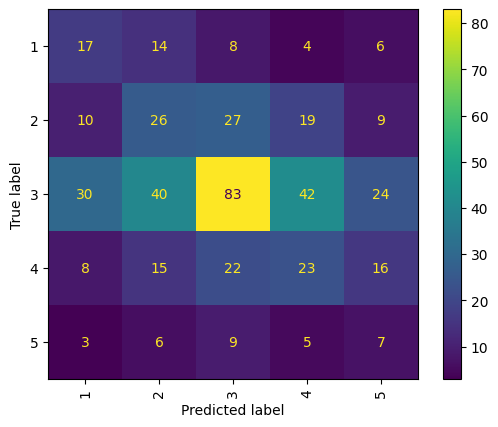

In [23]:
# Convert data to DMatrix format
dtrain = DMatrix(train_features_resampled, label=train_labels_resampled - 1)
dval = DMatrix(val_features, label=val_labels - 1)

# Define the custom F1 evaluation function
def f1_eval_metric(preds, dtrain):
    labels = dtrain.get_label()  # True labels
    preds = preds.argmax(axis=1)  # Convert probabilities to predicted classes
    f1 = f1_score(labels, preds, average='macro')  # Use 'macro' F1-score
    return 'f1_score', f1

# Define training parameters
params = {
    'objective': 'multi:softprob',  # Multiclass classification with probabilities
    'num_class': 5,  # Number of classes
    'learning_rate': 0.2,
    'max_depth': 6,
    'random_state': 42,
}

# Train the model with custom evaluation metric
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = train(
    params,
    dtrain,
    num_boost_round=200,  # Replaces n_estimators
    evals=evals,
    custom_metric=f1_eval_metric,  # Use custom_metric instead of feval
    early_stopping_rounds=10,  # Stop if no improvement
    verbose_eval=True,
)

# Make predictions
val_preds = bst.predict(dval)
val_preds = val_preds.argmax(axis=1) + 1  # Convert back to 1-based labels

# Evaluate the results
print("Validation F1-Score (macro):", f1_score(val_labels, val_preds, average='macro'))
print("Classification Report:\n", classification_report(val_labels, val_preds))

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()

## 1. Dimensionality Reduction (Feature Selection or Feature Engineering): CORRELATION ANALYSIS

In [17]:
# Step 1: Compute Correlation Matrix
correlation_matrix = pd.DataFrame(train_features_resampled).corr()

# Step 2: Identify Highly Correlated Features (|correlation| > 0.90)
correlation_threshold = 0.80  # You can experiment with values like 0.85 or 0.90
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(i)  # Keep track of correlated feature indices

print(f"Found {len(correlated_features)} highly correlated features.")

Found 1247 highly correlated features.


In [18]:
# RUN THIS PART THE NEXT PART AFTER TRAINING THE XGBOOST CLASSIFIER
# Extract feature importance
feature_importance = bst.get_score(importance_type="gain")
feature_importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# Extract the numeric part of the feature names and convert to integers
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.extract('(\d+)').astype(int)

# Step 4: Remove Correlated Features with Lower Importance
features_to_keep = set(range(train_features_resampled.shape[1]))  # Start with all features

for i in correlated_features:
    if i in feature_importance_df['Feature'].values:
        # Get the importance score of correlated features
        importance_score = feature_importance_df.loc[feature_importance_df['Feature'] == i, 'Importance'].values[0]

        # Find another feature correlated with it
        correlated_feature = next(iter([f for f in correlated_features if f != i]), None)
        if correlated_feature is not None:
            correlated_importance = feature_importance_df.loc[
                feature_importance_df['Feature'] == correlated_feature, 'Importance'
            ].values[0]

            # Keep the feature with higher importance
            if importance_score > correlated_importance:
                features_to_keep.discard(correlated_feature)
            else:
                features_to_keep.discard(i)

print(f"Retaining {len(features_to_keep)} features after correlation filtering.")

Retaining 1145 features after correlation filtering.


In [19]:
# Step 5: Apply Feature Selection
train_features_selected = train_features_resampled[:, list(features_to_keep)]
val_features_selected = val_features[:, list(features_to_keep)]

print(f"New train feature shape: {train_features_selected.shape}")
print(f"New val feature shape: {val_features_selected.shape}")

New train feature shape: (4348, 1145)
New val feature shape: (473, 1145)


In [20]:
print(f"train_features_selected shape: {train_features_selected.shape}")
print(f"train_labels_resampled shape: {train_labels_resampled.shape}")

print(f"val_features_selected shape: {val_features_selected.shape}")
print(f"val_labels shape: {val_labels.shape}")

train_features_selected shape: (4348, 1145)
train_labels_resampled shape: (4348,)
val_features_selected shape: (473, 1145)
val_labels shape: (473,)


[0]	train-mlogloss:1.48247	train-f1_score:0.57042	eval-mlogloss:1.58920	eval-f1_score:0.27366
[1]	train-mlogloss:1.38274	train-f1_score:0.66311	eval-mlogloss:1.57774	eval-f1_score:0.26184
[2]	train-mlogloss:1.29127	train-f1_score:0.73209	eval-mlogloss:1.56403	eval-f1_score:0.25313
[3]	train-mlogloss:1.21352	train-f1_score:0.76054	eval-mlogloss:1.55245	eval-f1_score:0.26760
[4]	train-mlogloss:1.15655	train-f1_score:0.77782	eval-mlogloss:1.53892	eval-f1_score:0.26544
[5]	train-mlogloss:1.09107	train-f1_score:0.80542	eval-mlogloss:1.53075	eval-f1_score:0.28357
[6]	train-mlogloss:1.04207	train-f1_score:0.82362	eval-mlogloss:1.52468	eval-f1_score:0.27523
[7]	train-mlogloss:0.99011	train-f1_score:0.83965	eval-mlogloss:1.52179	eval-f1_score:0.27708
[8]	train-mlogloss:0.94135	train-f1_score:0.85600	eval-mlogloss:1.51409	eval-f1_score:0.28031
[9]	train-mlogloss:0.89767	train-f1_score:0.87101	eval-mlogloss:1.51041	eval-f1_score:0.29614
[10]	train-mlogloss:0.86407	train-f1_score:0.88068	eval-mlog

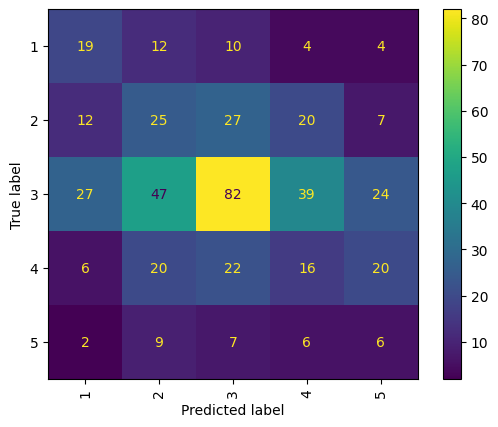

In [21]:
# Convert data to DMatrix format
dtrain = DMatrix(train_features_selected, label=train_labels_resampled - 1)
dval = DMatrix(val_features_selected, label=val_labels - 1)

# Define the custom F1 evaluation function
def f1_eval_metric(preds, dtrain):
    labels = dtrain.get_label()  # True labels
    preds = preds.argmax(axis=1)  # Convert probabilities to predicted classes
    f1 = f1_score(labels, preds, average='macro')  # Use 'macro' F1-score
    return 'f1_score', f1

# Define training parameters
params = {
    'objective': 'multi:softprob',  # Multiclass classification with probabilities
    'num_class': 5,  # Number of classes
    'learning_rate': 0.2,
    'max_depth': 6,
    'random_state': 42,
}

# Train the model with custom evaluation metric
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = train(
    params,
    dtrain,
    num_boost_round=200,  # Replaces n_estimators
    evals=evals,
    custom_metric=f1_eval_metric,  # Use custom_metric instead of feval
    early_stopping_rounds=10,  # Stop if no improvement
    verbose_eval=True,
)

# Make predictions
val_preds = bst.predict(dval)
val_preds = val_preds.argmax(axis=1) + 1  # Convert back to 1-based labels

# Evaluate the results
print("Validation F1-Score (macro):", f1_score(val_labels, val_preds, average='macro'))
print("Classification Report:\n", classification_report(val_labels, val_preds))

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()

Optimal threshold for class 1: 0.24457724392414093
Optimal threshold for class 2: 0.18079905211925507
Optimal threshold for class 3: 0.10517735034227371
Optimal threshold for class 4: 0.21795329451560974
Optimal threshold for class 5: 0.36154240369796753
Classification Report (Adjusted):
              precision    recall  f1-score   support

           1       0.30      0.39      0.34        49
           2       0.23      0.31      0.26        91
           3       0.56      0.41      0.47       219
           4       0.22      0.25      0.23        84
           5       0.21      0.20      0.21        30

    accuracy                           0.35       473
   macro avg       0.30      0.31      0.30       473
weighted avg       0.38      0.35      0.36       473



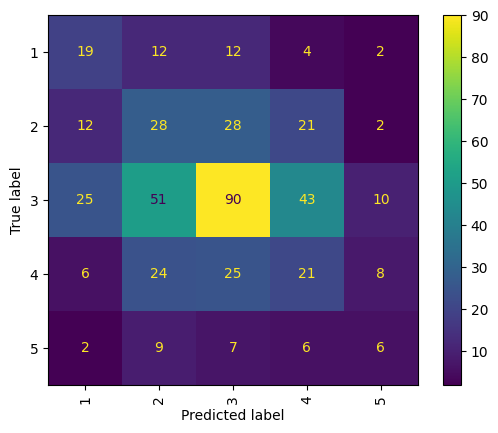

In [22]:
# Make predictions
val_preds_proba = bst.predict(dval)  # Get predicted probabilities

# Class-specific threshold tuning
optimal_thresholds = []
for i in range(1, 6):  # Loop through each class (1 to 5)
    class_indices = (val_labels == i).astype(int)  # Convert to binary labels for class i
    precision, recall, thresholds = precision_recall_curve(class_indices, val_preds_proba[:, i-1])
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)  # Avoid division by zero
    optimal_idx = f1_scores.argmax()  # Find the index of the maximum F1-score
    optimal_threshold = thresholds[optimal_idx]  # Get the corresponding threshold
    optimal_thresholds.append(optimal_threshold)  # Save the optimal threshold
    print(f"Optimal threshold for class {i}: {optimal_threshold}")

# Adjust predictions based on the optimal thresholds
adjusted_preds = []
for probs in val_preds_proba:  # Loop through predicted probabilities
    predicted_class = np.argmax([p if p >= optimal_thresholds[i] else 0 for i, p in enumerate(probs)]) + 1
    adjusted_preds.append(predicted_class)

# Evaluate the adjusted predictions
print("Classification Report (Adjusted):")
print(classification_report(val_labels, adjusted_preds))

# Optional: Compute and display the confusion matrix
cm = confusion_matrix(val_labels, adjusted_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()

## 2. Dimensionality Reduction (Feature Selection or Feature Engineering): SHAP ANALYSIS

Computing SHAP values for training data...
SHAP values shape: (4348, 1280, 5)
Generating SHAP summary plot...


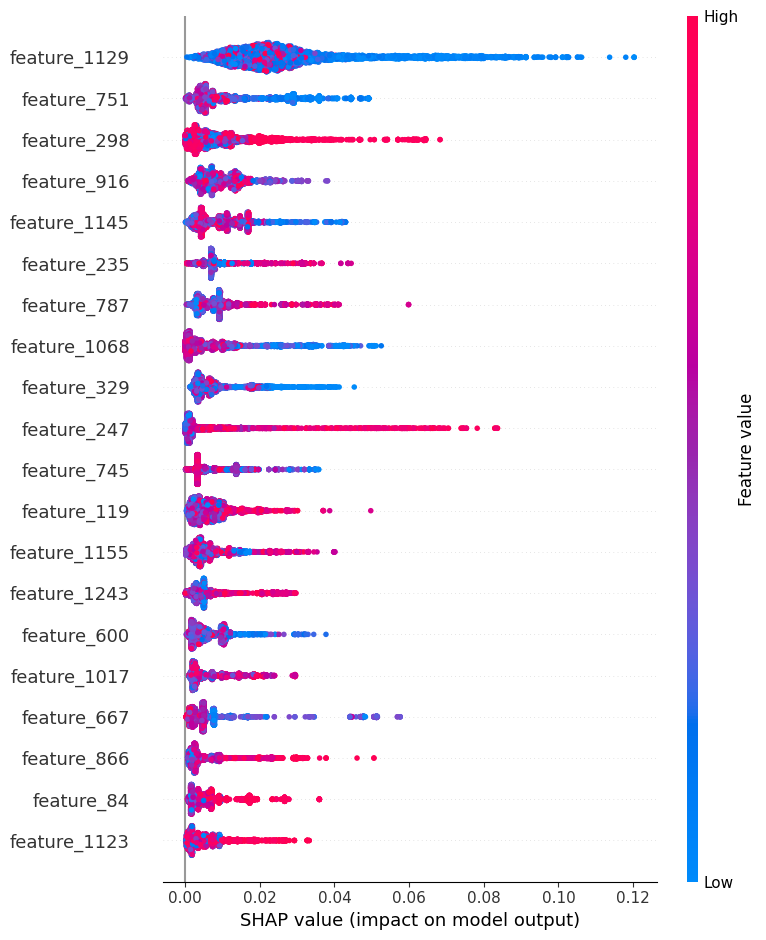

In [24]:
# Initialize SHAP TreeExplainer for the trained XGBoost model
explainer = shap.TreeExplainer(bst)

# Compute SHAP values for the training dataset
print("Computing SHAP values for training data...")
shap_values = explainer.shap_values(train_features_resampled)

# Check the shape of SHAP values
print(f"SHAP values shape: {np.array(shap_values).shape}")  # Expected: (num_samples, num_features)

# Visualize feature importance using a SHAP summary plot
print("Generating SHAP summary plot...")
# Aggregate SHAP values across classes (mean of absolute values)
shap_values_mean = np.abs(shap_values).mean(axis=2)

# Generate the SHAP summary plot
shap.summary_plot(shap_values_mean, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

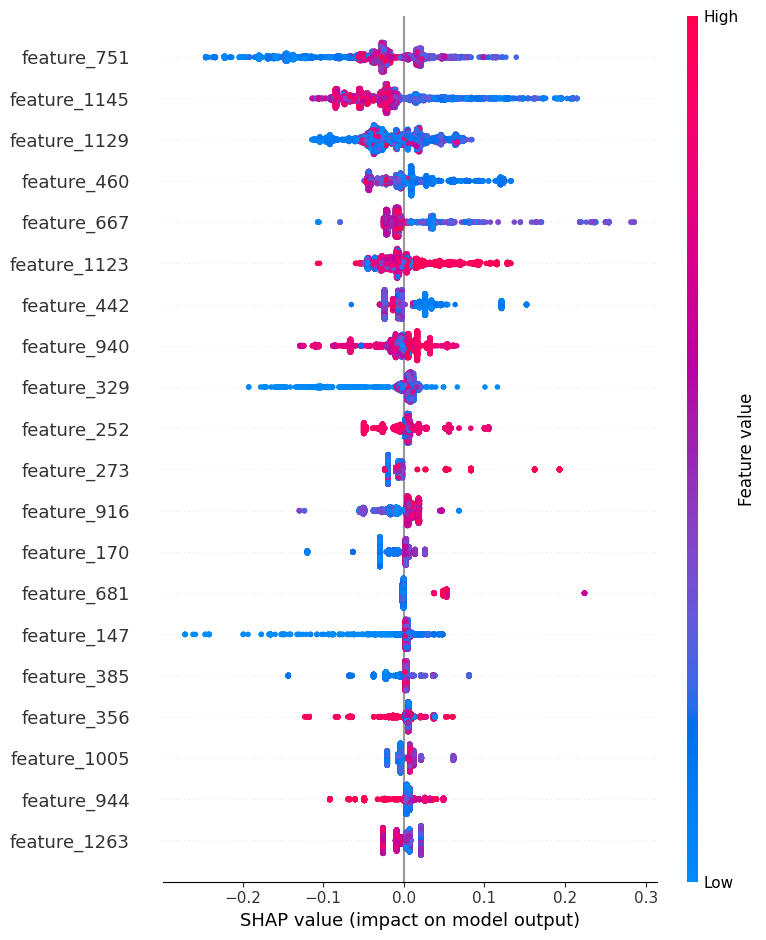

In [26]:
# Example: SHAP values for class 1 (index 4 for zero-based indexing)
class_index = 0
shap_values_class_5 = shap_values[:, :, class_index]

# Summary plot for class 5
shap.summary_plot(shap_values_class_5, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

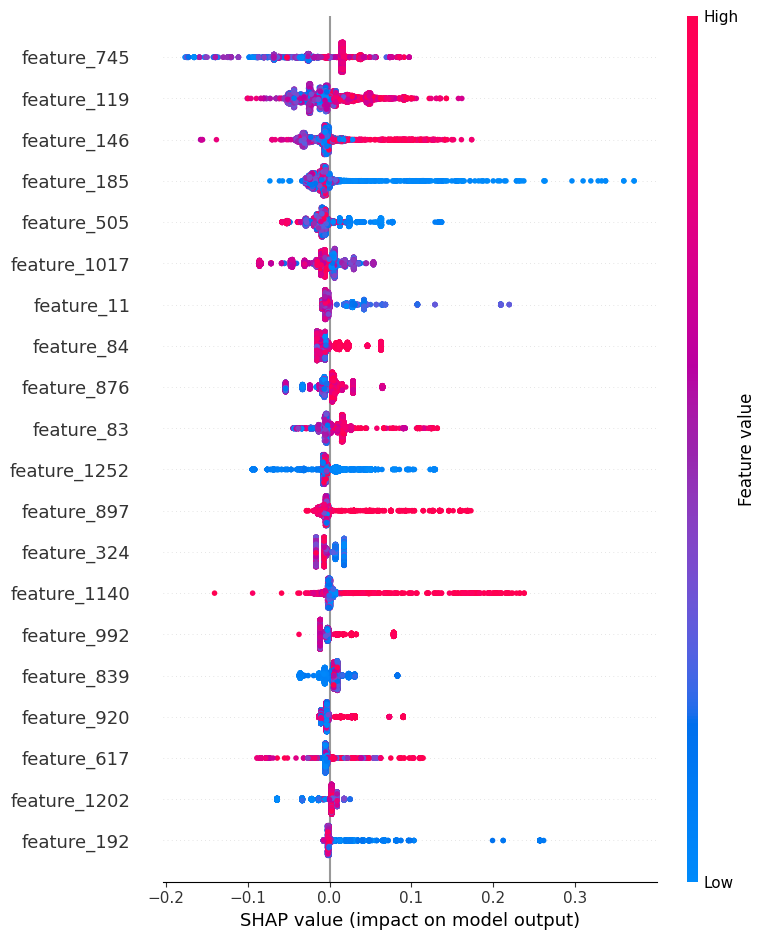

In [27]:
# Example: SHAP values for class 2 (index 4 for zero-based indexing)
class_index = 1
shap_values_class_5 = shap_values[:, :, class_index]

# Summary plot for class 5
shap.summary_plot(shap_values_class_5, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

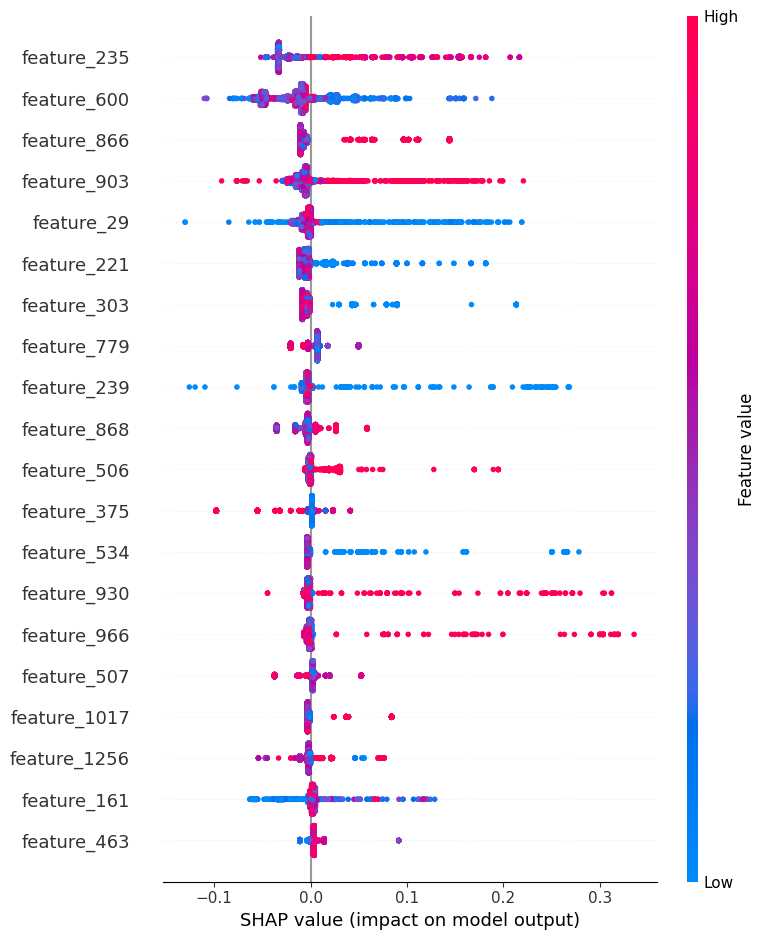

In [28]:
# Example: SHAP values for class 3 (index 4 for zero-based indexing)
class_index = 2
shap_values_class_5 = shap_values[:, :, class_index]

# Summary plot for class 5
shap.summary_plot(shap_values_class_5, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

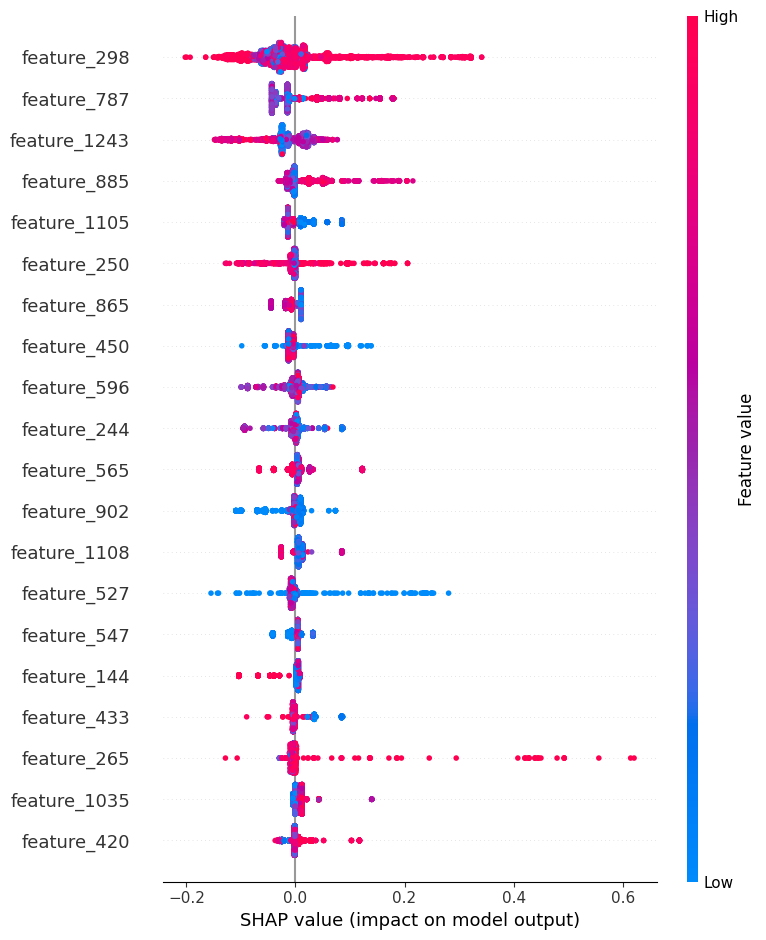

In [30]:
# Example: SHAP values for class 4 (index 4 for zero-based indexing)
class_index = 3
shap_values_class_5 = shap_values[:, :, class_index]

# Summary plot for class 5
shap.summary_plot(shap_values_class_5, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

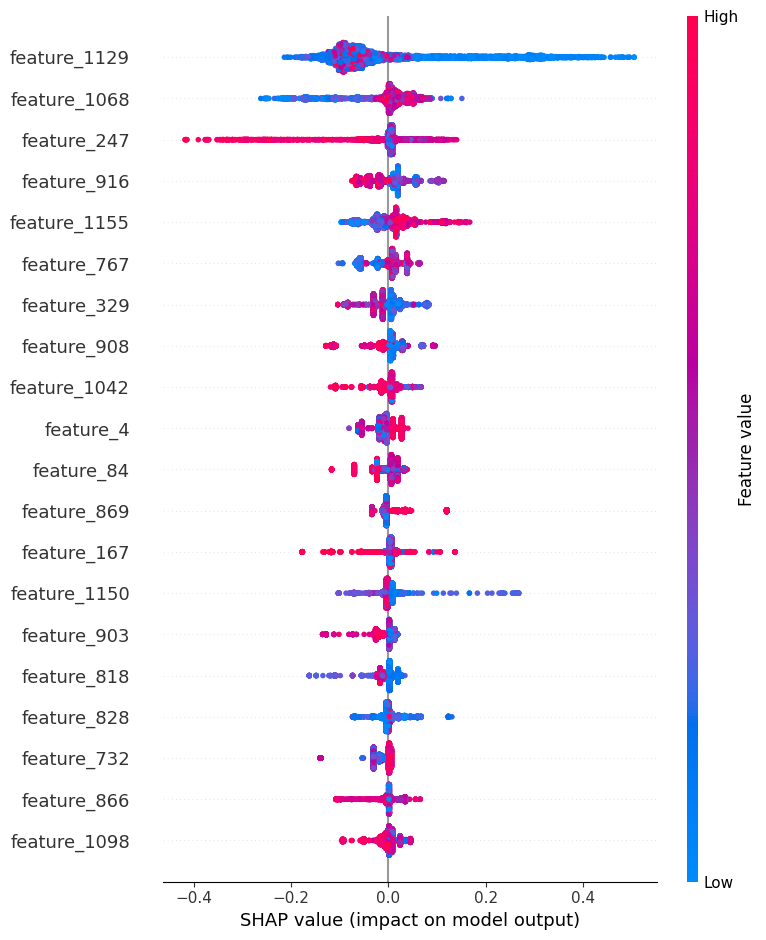

In [31]:
# Example: SHAP values for class 5 (index 4 for zero-based indexing)
class_index = 4
shap_values_class_5 = shap_values[:, :, class_index]

# Summary plot for class 5
shap.summary_plot(shap_values_class_5, train_features_resampled, feature_names=[f"feature_{i}" for i in range(train_features_resampled.shape[1])])

In [32]:
# Indices of features to remove
features_to_remove = [1129]

# Remove features from train and validation feature matrices
train_features_filtered = np.delete(train_features_resampled, features_to_remove, axis=1)
val_features_filtered = np.delete(val_features, features_to_remove, axis=1)

print(f"Original train features shape: {train_features_resampled.shape}")
print(f"Filtered train features shape: {train_features_filtered.shape}")
print(f"Original val features shape: {val_features.shape}")
print(f"Filtered val features shape: {val_features_filtered.shape}")

Original train features shape: (4348, 1280)
Filtered train features shape: (4348, 1279)
Original val features shape: (473, 1280)
Filtered val features shape: (473, 1279)


[0]	train-mlogloss:1.48782	train-f1_score:0.56376	eval-mlogloss:1.59051	eval-f1_score:0.26682
[1]	train-mlogloss:1.38888	train-f1_score:0.65224	eval-mlogloss:1.58048	eval-f1_score:0.27207
[2]	train-mlogloss:1.30431	train-f1_score:0.71914	eval-mlogloss:1.56869	eval-f1_score:0.26212
[3]	train-mlogloss:1.22181	train-f1_score:0.76078	eval-mlogloss:1.55581	eval-f1_score:0.26278
[4]	train-mlogloss:1.15457	train-f1_score:0.78989	eval-mlogloss:1.54517	eval-f1_score:0.27580
[5]	train-mlogloss:1.09047	train-f1_score:0.81973	eval-mlogloss:1.53390	eval-f1_score:0.26896
[6]	train-mlogloss:1.03407	train-f1_score:0.83433	eval-mlogloss:1.52514	eval-f1_score:0.27344
[7]	train-mlogloss:0.98467	train-f1_score:0.85241	eval-mlogloss:1.51824	eval-f1_score:0.27499
[8]	train-mlogloss:0.94615	train-f1_score:0.86182	eval-mlogloss:1.51185	eval-f1_score:0.28346
[9]	train-mlogloss:0.89912	train-f1_score:0.87784	eval-mlogloss:1.50683	eval-f1_score:0.27701
[10]	train-mlogloss:0.86756	train-f1_score:0.88252	eval-mlog

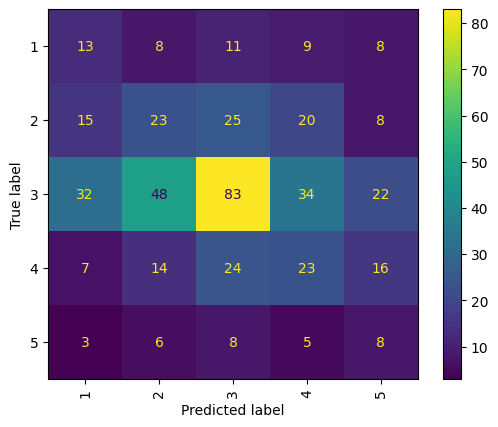

In [33]:
# Convert data to DMatrix format
dtrain = DMatrix(train_features_filtered, label=train_labels_resampled - 1)
dval = DMatrix(val_features_filtered, label=val_labels - 1)

# Define the custom F1 evaluation function
def f1_eval_metric(preds, dtrain):
    labels = dtrain.get_label()  # True labels
    preds = preds.argmax(axis=1)  # Convert probabilities to predicted classes
    f1 = f1_score(labels, preds, average='macro')  # Use 'macro' F1-score
    return 'f1_score', f1

# Define training parameters
params = {
    'objective': 'multi:softprob',  # Multiclass classification with probabilities
    'num_class': 5,  # Number of classes
    'learning_rate': 0.2,
    'max_depth': 6,
    'random_state': 42,
}

# Train the model with custom evaluation metric
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = train(
    params,
    dtrain,
    num_boost_round=200,  # Replaces n_estimators
    evals=evals,
    custom_metric=f1_eval_metric,  # Use custom_metric instead of feval
    early_stopping_rounds=10,  # Stop if no improvement
    verbose_eval=True,
)

# Make predictions
val_preds = bst.predict(dval)
val_preds = val_preds.argmax(axis=1) + 1  # Convert back to 1-based labels

# Evaluate the results
print("Validation F1-Score (macro):", f1_score(val_labels, val_preds, average='macro'))
print("Classification Report:\n", classification_report(val_labels, val_preds))

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()

## 3. Dimensionality Reduction (Feature Selection or Feature Engineering): PCA

Option 1: Choosing principal components higher than ...% variance

In [36]:
# Standardize the training and validation features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

# Initialize PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance

# Fit PCA on training features and transform both train and validation sets
train_features_pca = pca.fit_transform(train_features_scaled)
val_features_pca = pca.transform(val_features_scaled)

# Check the new shapes
print(f"Reduced train features shape: {train_features_pca.shape}")
print(f"Reduced val features shape: {val_features_pca.shape}")

Reduced train features shape: (1890, 3)
Reduced val features shape: (473, 3)


Option 2: Choosing first n principal components

In [39]:
# Reduce to a fixed number of components
pca = PCA(n_components=25)
train_features_pca = pca.fit_transform(train_features_scaled)
val_features_pca = pca.transform(val_features_scaled)

print(f"Reduced train features shape: {train_features_pca.shape}")
print(f"Reduced val features shape: {val_features_pca.shape}")

Reduced train features shape: (1890, 25)
Reduced val features shape: (473, 25)


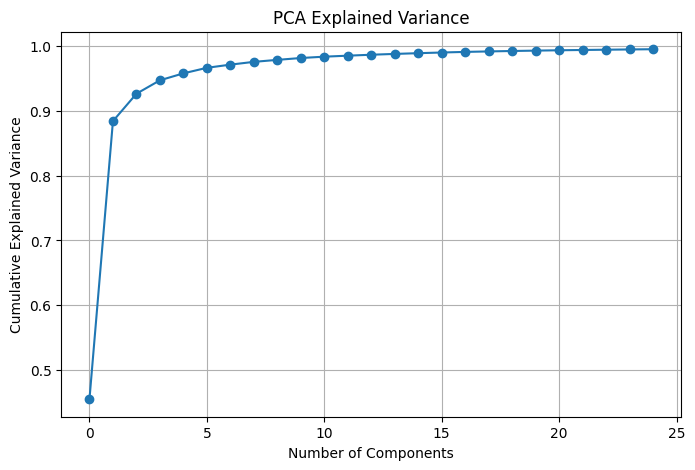

In [40]:
# Cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

[0]	train-mlogloss:1.49142	train-f1_score:0.45758	eval-mlogloss:1.54407	eval-f1_score:0.19860
[1]	train-mlogloss:1.40137	train-f1_score:0.47114	eval-mlogloss:1.50562	eval-f1_score:0.18946
[2]	train-mlogloss:1.31606	train-f1_score:0.51135	eval-mlogloss:1.47550	eval-f1_score:0.18021
[3]	train-mlogloss:1.24464	train-f1_score:0.54854	eval-mlogloss:1.44873	eval-f1_score:0.20100
[4]	train-mlogloss:1.17363	train-f1_score:0.60117	eval-mlogloss:1.42839	eval-f1_score:0.20406
[5]	train-mlogloss:1.11798	train-f1_score:0.61612	eval-mlogloss:1.41627	eval-f1_score:0.19831
[6]	train-mlogloss:1.06027	train-f1_score:0.63996	eval-mlogloss:1.40655	eval-f1_score:0.20586
[7]	train-mlogloss:1.02335	train-f1_score:0.64860	eval-mlogloss:1.39353	eval-f1_score:0.20606
[8]	train-mlogloss:0.98251	train-f1_score:0.66571	eval-mlogloss:1.39095	eval-f1_score:0.20489
[9]	train-mlogloss:0.94033	train-f1_score:0.67609	eval-mlogloss:1.38842	eval-f1_score:0.20182
[10]	train-mlogloss:0.89887	train-f1_score:0.70636	eval-mlog

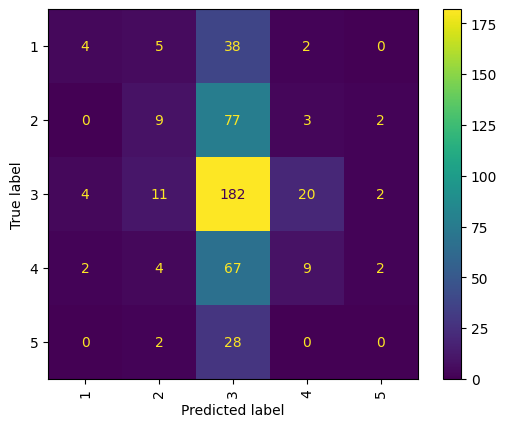

In [41]:
# Use train_features_pca and val_features_pca in your XGBoost model
dtrain = DMatrix(train_features_pca, label=train_labels - 1)
dval = DMatrix(val_features_pca, label=val_labels - 1)

# Define the custom F1 evaluation function
def f1_eval_metric(preds, dtrain):
    labels = dtrain.get_label()  # True labels
    preds = preds.argmax(axis=1)  # Convert probabilities to predicted classes
    f1 = f1_score(labels, preds, average='macro')  # Use 'macro' F1-score
    return 'f1_score', f1

# Define training parameters
params = {
    'objective': 'multi:softprob',  # Multiclass classification with probabilities
    'num_class': 5,  # Number of classes
    'learning_rate': 0.2,
    'max_depth': 6,
    'random_state': 42
}

# Train the model with custom evaluation metric
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = train(
    params,
    dtrain,
    num_boost_round=200,  # Replaces n_estimators
    evals=evals,
    custom_metric=f1_eval_metric,  # Use custom_metric instead of feval
    early_stopping_rounds=10,  # Stop if no improvement
    verbose_eval=True,
)

# Make predictions
val_preds = bst.predict(dval)
val_preds = val_preds.argmax(axis=1) + 1  # Convert back to 1-based labels

# Evaluate the results
print("Validation F1-Score (macro):", f1_score(val_labels, val_preds, average='macro'))
print("Classification Report:\n", classification_report(val_labels, val_preds))

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.show()